<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/worldCup_2022_randomForest_logisticRegression_vs_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##INSTALL

In [1]:
!pip install dicttoxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##IMPORTS

In [2]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
from dicttoxml import dicttoxml

##FUNCTIONS

In [3]:
_page = None

def get_html_page(cache):
    global _page
    
    if cache is False:
        _page = None
    if _page is None:
        html = urlopen('https://www.placardefutebol.com.br/')
        _page = BeautifulSoup(html, 'lxml')
        
    res = _page
    
    return res
    

def today_games(format='dict', cache=True):
    page = get_html_page(cache)
    titles = page.find_all('h3', class_='match-list_league-name')
    championships = page.find_all('div', class_='container content')
    
    results = []
    
    for id, championship in enumerate(championships):
        matchs = championship.find_all('div', class_='row align-items-center content')
        
        for match in matchs:
            status = match.find('span', class_='status-name').text
            teams = match.find_all('div', class_='team-name')
            status = match.find('span', class_='status-name').text
            scoreboard = match.find_all('span', class_='badge badge-default')
            
            team_home = teams[0].text.strip()
            team_visitor = teams[1].text.strip()
            
            info = {
                'match': '{} x {}'.format(team_home, team_visitor),
                'status': status,
                'league': titles[id].text,
            }
            
            score = {}
            
            # Se o jogo já começou então existe placar.
            try:
                score['scoreboard'] = {
                    team_home: scoreboard[0].text,
                    team_visitor: scoreboard[1].text
                }
                score['summary'] = '{} x {}'.format(scoreboard[0].text, scoreboard[1].text)
            # Caso não tenha começado, armazena o horário de início
            except:
                score['start_in'] = status
                score['status'] = 'EM BREVE'
            
            info.update(score)
            
            results.append(info)
        
    if (format == 'json'):
        return json.dumps(results)
    elif (format == 'xml'):
        return dicttoxml(results)
    else:
        return results

  
def live_games(format='dict', cache=True):
    matchs = today_games(cache=cache)
    results = list(filter(lambda match: re.findall(r'INTERVALO | AO VIVO | MIN', match['status']), matchs))
    
    if (format == 'json'):
        return json.dumps(results)
    elif (format == 'xml'):
        return dicttoxml(results)
    else:
        return results
        
def search_game_by_team(time, cache=True):
    matchs = today_games(cache=cache)
    return list(filter(lambda match: time.lower() in match['match'].lower(), matchs))

##IS THERE A TEAM _____ GAME TODAY?

In [4]:
search_game_by_team('equador')

[{'match': 'Qatar x Equador',
  'status': 'ENCERRADO',
  'league': 'MAIS POPULARES AGORA',
  'scoreboard': {'Qatar': '0', 'Equador': '2'},
  'summary': '0 x 2'}]

##SIMULATOR _1

In [5]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/digitalinnovationone/live-coding-evitando-o-7x1-com-python-e-sql/main/data.csv')
df.head()

,A,B,C,D,E,F,G,H
0,CAT|1442.0,EUA|1635.0,ARG|1770.7,AUS|1483.7,ALE|1659.0,BEL|1821.9,BRA|1837.6,COR|1526.0
1,EQU|1463.7,ING|1737.5,ARA|1435.7,DIN|1665.5,COS|1500.1,CAN|1473.8,CAM|1485.0,GAN|1393.5
2,HOL|1679.4,IRA|1558.6,MEX|1649.6,FRA|1764.9,ESP|1716.9,CRO|1632.2,SUI|1621.4,POR|1678.7
3,SEN|1584.6,GAL|1582.1,POL|1546.2,TUN|1507.9,JAP|1554.7,MAR|1558.4,SER|1549.5,URU|1641.0


### DEFINIR UM CONSTRUTOR COM OS ATRIBUTOS ADEQUADOS BASEADO NO ARQUIVO BASE IMPORTADO (DATA.CSV)

In [6]:
import random

class Team:
  BEST_SCORE = 1837.6

  def __init__(self, cellData):
    teamData = cellData.split('|')
    self.name = teamData[0]
    self.score = float(teamData[1])

  def motivate(self):
    self.lastMotivation = random.uniform(70, (self.score * 100) / Team.BEST_SCORE)
    return self.lastMotivation

###SIMULANDO A FASE DE GRUPOS

In [7]:
bestTeamsByGroup = {}

for label, content in df.items():
  team1 = Team(content[0])
  team2 = Team(content[1])
  team3 = Team(content[2])
  team4 = Team(content[3])
  
  bestTeamsByGroup[label] = sorted([team1, team2, team3, team4], key=Team.motivate, reverse=True)

for grupo, motivatedTeams in bestTeamsByGroup.items():
  print(f'Grupo {grupo}: ', end="")
  for team in motivatedTeams:
    print(f'{team.name} ({team.lastMotivation:.2f}) ', end="")
  print()

Grupo A: SEN (80.71) HOL (79.81) CAT (72.81) EQU (71.44) 
Grupo B: EUA (88.63) GAL (85.99) ING (72.05) IRA (70.70) 
Grupo C: MEX (82.90) POL (82.61) ARG (79.67) ARA (72.87) 
Grupo D: DIN (87.52) AUS (78.78) FRA (78.77) TUN (78.13) 
Grupo E: ALE (86.61) COS (80.24) JAP (74.26) ESP (71.56) 
Grupo F: MAR (81.60) CRO (75.04) BEL (74.46) CAN (70.89) 
Grupo G: CAM (80.39) BRA (78.63) SUI (76.18) SER (71.87) 
Grupo H: URU (88.03) GAN (74.88) COR (72.81) POR (70.85) 


###SIMULANDO AS OITAVAS DE FINAL

In [8]:
team1A = bestTeamsByGroup['A'][0]
team2A = bestTeamsByGroup['A'][1]
team1B = bestTeamsByGroup['B'][0]
team2B = bestTeamsByGroup['B'][1]
team1C = bestTeamsByGroup['C'][0]
team2C = bestTeamsByGroup['C'][1]
team1D = bestTeamsByGroup['D'][0]
team2D = bestTeamsByGroup['D'][1]
team1E = bestTeamsByGroup['E'][0]
team2E = bestTeamsByGroup['E'][1]
team1F = bestTeamsByGroup['F'][0]
team2F = bestTeamsByGroup['F'][1]
team1G = bestTeamsByGroup['G'][0]
team2G = bestTeamsByGroup['G'][1]
team1H = bestTeamsByGroup['H'][0]
team2H = bestTeamsByGroup['H'][1]

quarter1 = team1A if team1A.motivate() > team2B.motivate() else team2B
quarter2 = team1C if team1C.motivate() > team2D.motivate() else team2D
quarter3 = team1E if team1E.motivate() > team2F.motivate() else team2F
quarter4 = team1G if team1G.motivate() > team2H.motivate() else team2H
quarter5 = team1B if team1B.motivate() > team2A.motivate() else team2A
quarter6 = team1D if team1D.motivate() > team2C.motivate() else team2C
quarter7 = team1F if team1F.motivate() > team2E.motivate() else team2E
quarter8 = team1H if team1H.motivate() > team2G.motivate() else team2G

print(f'{team1A.name} ({team1A.lastMotivation:.2f}) x {team2B.name} ({team2B.lastMotivation:.2f})')
print(f'{team1C.name} ({team1C.lastMotivation:.2f}) x {team2D.name} ({team2D.lastMotivation:.2f})')
print(f'{team1E.name} ({team1E.lastMotivation:.2f}) x {team2F.name} ({team2F.lastMotivation:.2f})')
print(f'{team1G.name} ({team1G.lastMotivation:.2f}) x {team2H.name} ({team2H.lastMotivation:.2f})')
print(f'{team1B.name} ({team1B.lastMotivation:.2f}) x {team2A.name} ({team2A.lastMotivation:.2f})')
print(f'{team1D.name} ({team1D.lastMotivation:.2f}) x {team2C.name} ({team2C.lastMotivation:.2f})')
print(f'{team1F.name} ({team1F.lastMotivation:.2f}) x {team2E.name} ({team2E.lastMotivation:.2f})')
print(f'{team1H.name} ({team1H.lastMotivation:.2f}) x {team2G.name} ({team2G.lastMotivation:.2f})')

SEN (84.43) x GAL (82.27)
MEX (71.51) x AUS (80.32)
ALE (85.80) x CRO (72.52)
CAM (72.09) x GAN (71.96)
EUA (84.49) x HOL (81.75)
DIN (72.37) x POL (79.62)
MAR (70.39) x COS (76.77)
URU (76.39) x BRA (82.05)


###SIMULANDO AS QUARTAS DE FINAL

In [9]:
semi1 = quarter1 if quarter1.motivate() > quarter2.motivate() else quarter2
semi2 = quarter3 if quarter3.motivate() > quarter4.motivate() else quarter4
semi3 = quarter5 if quarter5.motivate() > quarter6.motivate() else quarter6
semi4 = quarter7 if quarter7.motivate() > quarter8.motivate() else quarter8

print(f'{quarter1.name} ({quarter1.lastMotivation:.2f}) x {quarter2.name} ({quarter2.lastMotivation:.2f})')
print(f'{quarter3.name} ({quarter3.lastMotivation:.2f}) x {quarter4.name} ({quarter4.lastMotivation:.2f})')
print(f'{quarter5.name} ({quarter5.lastMotivation:.2f}) x {quarter6.name} ({quarter6.lastMotivation:.2f})')
print(f'{quarter7.name} ({quarter7.lastMotivation:.2f}) x {quarter8.name} ({quarter8.lastMotivation:.2f})')

SEN (85.26) x AUS (72.38)
ALE (75.35) x CAM (74.99)
EUA (82.82) x POL (81.10)
COS (70.93) x BRA (86.72)


###SIMULANDO AS SEMIFINAIS

In [10]:
final1 = semi1 if semi1.motivate() > semi2.motivate() else semi2
terceiro1 = semi1 if semi1.lastMotivation < semi2.lastMotivation else semi2

final2 = None
terceiro2 = None
if semi3.motivate() > semi4.motivate():
  final2 = semi3
  terceiro2 = semi4
else:
  final2 = semi4
  terceiro2 = semi3

print(f'{semi1.name} ({semi1.lastMotivation:.2f}) x {semi2.name} ({semi2.lastMotivation:.2f})')
print(f'{semi3.name} ({semi3.lastMotivation:.2f}) x {semi4.name} ({semi4.lastMotivation:.2f})')

SEN (73.76) x ALE (76.66)
EUA (84.10) x BRA (80.95)


###SIMULANDO A FINAL

In [11]:
winner = final1 if final1.motivate() > final2.motivate() else final2
second = final1 if final1.lastMotivation < final2.lastMotivation else final2
third = terceiro1 if terceiro1.motivate() > terceiro2.motivate() else terceiro2
fourth = terceiro1 if terceiro1.lastMotivation < terceiro2.lastMotivation else terceiro2

print(f'1º: {winner.name} ({winner.lastMotivation:.2f})')
print(f'2º: {second.name} ({second.lastMotivation:.2f})')
print(f'3º: {third.name} ({third.lastMotivation:.2f})')
print(f'4º: {fourth.name} ({fourth.lastMotivation:.2f})')

1º: ALE (76.16)
2º: EUA (74.55)
3º: BRA (83.58)
4º: SEN (74.13)


##SIMULATOR _2

###DATA PREPARATION

In [12]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
from IPython.display import Image
random_num=122

In [13]:
df = pd.read_csv('/content/results.csv')
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
44147,2022-12-01,Canada,Morocco,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44148,2022-12-02,Serbia,Switzerland,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44149,2022-12-02,Cameroon,Brazil,NaN,NaN,FIFA World Cup,Lusail,Qatar,True
44150,2022-12-02,Ghana,Uruguay,NaN,NaN,FIFA World Cup,Al Wakrah,Qatar,True


In [14]:
df.describe()

,home_score,away_score
count,44104.000000,44104.000000
mean,1.740046,1.178102
std,1.747194,1.394679
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [15]:
df.isnull().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [16]:
##Suponha que o máximo de gols que um time pode marcar é 15

higher_home=10
higher_away=10
df=df[(df["home_score"]<higher_home) & (df["away_score"]<higher_away)]
df.head(5)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [17]:
#Criando uma nova coluna chamada "Win_Statues" para armazenar o resultado (Vitória, Perda, Empate) do time da casa

conditions  = [df["home_score"] ==df["away_score"], df["home_score"] > df["away_score"] , df["home_score"] < df["away_score"]]
choices     = [ "Draw", 'Win', 'Lost' ]
df["Win_Statues"] = np.select(conditions, choices)
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win


In [18]:
#Veja quais são os Países no conjunto de dados

countries=df.home_team.unique()
print(f"There are {len(countries)} Countries in the home_team Column\n")
print(f"Countries-{countries}")

There are 307 Countries in the home_team Column

Countries-['Scotland' 'England' 'Wales' 'Northern Ireland' 'United States' 'Uruguay'
 'Austria' 'Hungary' 'Argentina' 'Belgium' 'France' 'Netherlands'
 'Czechoslovakia' 'Switzerland' 'Germany' 'Italy' 'Chile' 'Norway'
 'Sweden' 'Finland' 'Luxembourg' 'Russia' 'Denmark' 'Catalonia'
 'Basque Country' 'Brazil' 'Paraguay' 'Japan' 'Canada' 'Estonia'
 'Costa Rica' 'Guatemala' 'Spain' 'Brittany' 'Poland' 'Yugoslavia'
 'New Zealand' 'Romania' 'Latvia' 'Galicia' 'Portugal' 'Andalusia'
 'China PR' 'Australia' 'Lithuania' 'Turkey' 'Central Spain' 'Mexico'
 'Aruba' 'Haiti' 'Philippines' 'Bulgaria' 'Jamaica' 'Kenya' 'Bolivia'
 'Peru' 'Honduras' 'Guyana' 'Uganda' 'Belarus' 'El Salvador' 'Barbados'
 'Republic of Ireland' 'Trinidad and Tobago' 'Greece' 'Curaçao' 'Egypt'
 'Dominica' 'Silesia' 'Guadeloupe' 'Israel' 'Suriname' 'French Guiana'
 'Cuba' 'Colombia' 'Ecuador' 'Saint Kitts and Nevis' 'Panama' 'Slovakia'
 'Manchukuo' 'Croatia' 'Nicaragua' 'Afghan

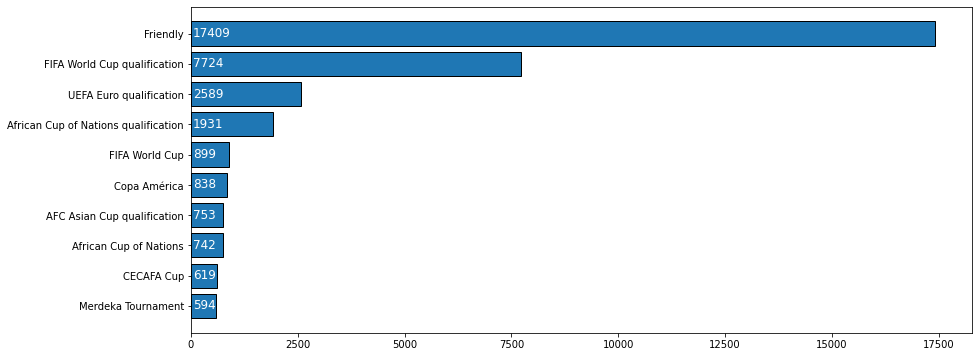

In [19]:
#Tipo de partidas
rank_bound = 10
ax = df.tournament.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

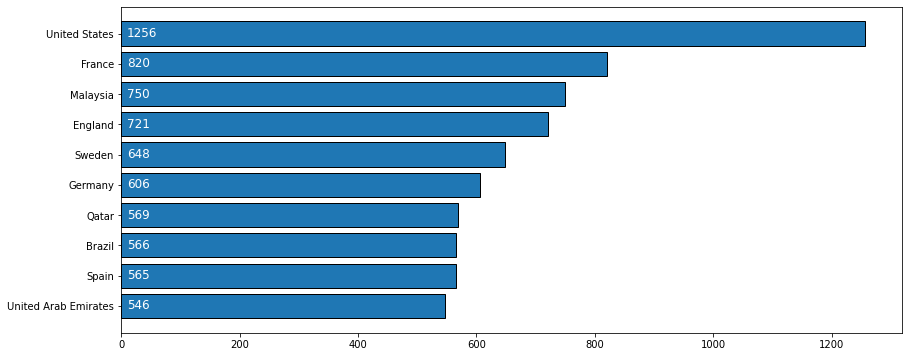

In [20]:
#As equipes jogaram a maioria das partidas
rank_bound = 10
ax = df.country.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=10,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

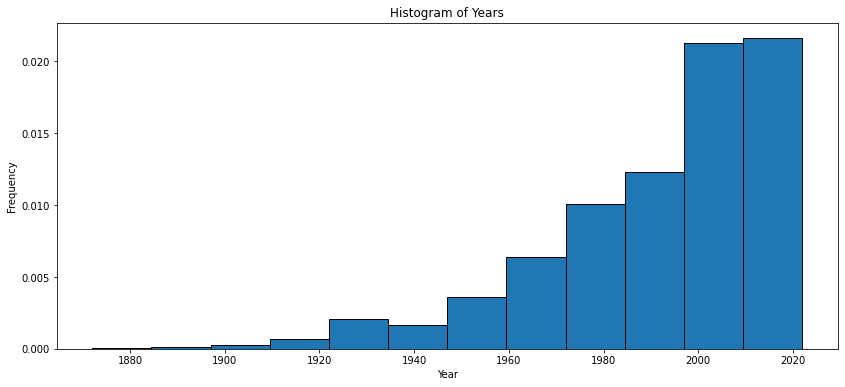

In [21]:
#Número de partidas disputadas em intervalos iguais

years = []
for date in df.date:
    years.append(int(str(date)[0:4]))
plt.figure(figsize=(14,6))
plt.hist(years, density=True, bins=12, edgecolor="k")
plt.title("Histogram of Years")
plt.ylabel("Frequency")
plt.xlabel("Year")
plt.show()

In [22]:
#Descobrir o impacto de sediar um grande torneio ajuda nas chances de vitória de um país?
#Agora pegue os rpws que home_team==Country
#Nad romover os dados dos amistosos

data_home=df.loc[df["home_team"]==df["country"] ]
data_home=df.loc[df["tournament"] != "Friendly"]
data_home.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
29,1884-01-26,Northern Ireland,Scotland,0.0,5.0,British Championship,Belfast,Ireland,False,Lost
30,1884-02-09,Wales,Northern Ireland,6.0,0.0,British Championship,Wrexham,Wales,False,Win
31,1884-02-23,Northern Ireland,England,1.0,8.0,British Championship,Belfast,Ireland,False,Lost
32,1884-03-15,Scotland,England,1.0,0.0,British Championship,Glasgow,Scotland,False,Win
33,1884-03-17,Wales,England,0.0,4.0,British Championship,Wrexham,Wales,False,Lost


In [23]:
# Estatísticas de vitórias do time da casa
#Como o time da casa se sai nas partidas do torneio

tournament_df=pd.crosstab(data_home["tournament"], data_home["Win_Statues"],margins=True)
tournament_df=tournament_df.sort_values("All",ascending=False).head(10)
tournament_df.style.bar(color="brown",subset=["Draw","Lost","Win","All"])

Win_Statues,Draw,Lost,Win,All
tournament,,,,
All,5791,7540,13113,26444
FIFA World Cup qualification,1644,2124,3956,7724
UEFA Euro qualification,510,817,1262,2589
African Cup of Nations qualification,472,378,1081,1931
FIFA World Cup,199,290,410,899
Copa América,181,230,427,838
AFC Asian Cup qualification,126,188,439,753
African Cup of Nations,209,200,333,742
CECAFA Cup,147,185,287,619


Text(0.5, 1.0, 'Home Team Winning Status')

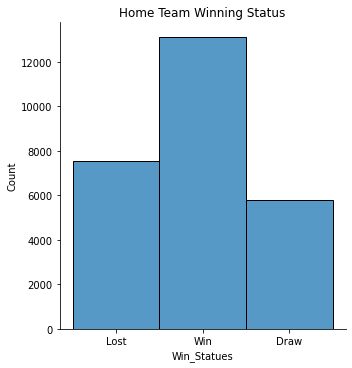

In [24]:
# Resultados do time da casa
sns.displot(data_home, x="Win_Statues")
plt.title("Home Team Winning Status")

In [25]:
data_home['Win_Statues'].value_counts()

Win     13113
Lost     7540
Draw     5791
Name: Win_Statues, dtype: int64

In [26]:
#Como cada equipe se sai durante um torneio em casa

teams_win_statues=pd.crosstab(df["home_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_win_statues["team_win_probability"]=teams_win_statues["Win"]/(teams_win_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_win_statues_100=teams_win_statues.loc[teams_win_statues["Total"]>50]
teams_win_statues_100=teams_win_statues_100.sort_values("team_win_probability",ascending=False)
teams_win_statues_100.head(20).style.bar(color="orange",subset="team_win_probability")

#Podemos ver que as equipes têm mais de 50% de probabilidade de vitória jogando em casa

Win_Statues,Draw,Lost,Win,Total,team_win_probability
home_team,,,,,
Brazil,110,58,422,590,0.715254
Spain,70,51,253,374,0.676471
Argentina,124,68,371,563,0.658970
Czech Republic,20,36,104,160,0.650000
Ivory Coast,67,35,183,285,0.642105
Egypt,69,74,256,399,0.641604
North Korea,23,22,79,124,0.637097
Nigeria,69,36,184,289,0.636678
Iran,63,44,184,291,0.632302


In [27]:
# Estatísticas de vitórias do time visitante
#Equipes jogando fora de casa

teams_away_statues=pd.crosstab(df["away_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_away_statues["team_win_probability"]=teams_away_statues["Lost"]/(teams_away_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_away_statues_100=teams_away_statues.loc[teams_away_statues["Total"]>50]
teams_away_statues_100=teams_away_statues_100.sort_values("team_win_probability",ascending=False)
teams_away_statues_100.rename(columns={'Lost': 'Win'}, index={'Win': 'Lost'}, inplace=True)
teams_away_statues_100.head(20)

#A probabilidade de ganhar um torneio fora de casa é muito baixa em comparação com as probabilidades de ganhar em casa

Win_Statues,Draw,Win,Win,Total,team_win_probability
away_team,,,,,
Brazil,95,228,102,425,0.536471
Germany,93,245,119,457,0.536105
England,136,265,117,518,0.511583
Spain,100,168,83,351,0.478632
Tahiti,16,50,43,109,0.458716
Croatia,49,83,50,182,0.456044
Iran,67,101,57,225,0.448889
South Korea,114,181,109,404,0.448020
Netherlands,83,167,129,379,0.440633


In [28]:
teams_away_statues_100["team_win_probability"]

away_team
Brazil           0.536471
Germany          0.536105
England          0.511583
Spain            0.478632
Tahiti           0.458716
                   ...   
Somalia          0.060606
Liechtenstein    0.058824
Seychelles       0.042254
Andorra          0.021505
San Marino       0.000000
Name: team_win_probability, Length: 198, dtype: float64

In [29]:
#fazendo uma cópia do dataframe principal para uso futuro
df_match=df.copy() 
df_match.head(8)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,Win
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,Lost
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,Lost


In [30]:
#Criando um novo conjunto de dados com os recursos necessários para treinar o modelo de aprendizado de máquina
#Ano,País Jogado,Team_1,team_2,pontuação do time_1,pontuação do time_2
New_Dataset_part_1=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,1],df_match.values[:,2],df_match.values[:,3],df_match.values[:,4])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])

#Criando um novo dataset alterando team_1 e team_2 e suas respectivas pontuações
New_Dataset_part_2=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,2],df_match.values[:,1],df_match.values[:,4],df_match.values[:,3])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])
New_Dataset=pd.concat([New_Dataset_part_1,New_Dataset_part_2],axis=0)
New_Dataset =New_Dataset.sample(frac=1).reset_index(drop=True) #Shaffling the dataset
New_Dataset.head(5)

,year,Country,team_1,team_2,team_1_score,team_2_score
0,2006,South Korea,South Korea,Iran,1.0,1.0
1,1969,South Korea,Australia,South Korea,2.0,1.0
2,1998,Gambia,Gambia,Zambia,0.0,2.0
3,1992,Benin,Niger,Benin,2.0,1.0
4,1955,Honduras,Costa Rica,Guatemala,2.0,0.0


In [31]:
#Criando uma lista contendo todos os nomes dos países
teams_1=New_Dataset.team_1.unique()
contries=New_Dataset.Country.unique()
all_countries=np.unique(np.concatenate((teams_1,contries), axis=0))
len(all_countries)

349

,year,team_1_score,team_2_score
year,1.000000,-0.128843,-0.128843
team_1_score,-0.128843,1.000000,-0.156674
team_2_score,-0.128843,-0.156674,1.000000


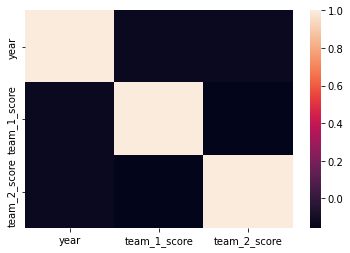

In [32]:
#Fazendo um mapa de calor para ver a correlação de cada coluna
sns.heatmap(New_Dataset.corr())
New_Dataset.corr()

In [33]:
#Definindo as features e labels(Targets)
Y= New_Dataset.iloc[:,4:6]                                                      # Metas de treinamento (team_1_score e team_2_score)
categorized_data=New_Dataset.iloc[:,0:4].copy()                                 # Recursos de treinamento

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

#Rotulando os dados usando LabelEncorder no Sklearn-(Dando um número único para cada string(país))
label_encoder.fit(all_countries)

#list(label_encoder.classes_)
categorized_data['team_1']=label_encoder.transform(categorized_data['team_1'])
categorized_data['team_2']=label_encoder.transform(categorized_data['team_2'])
categorized_data['Country']=label_encoder.transform(categorized_data['Country'])

#Convertendo essas colunas de recursos para categorizar o formulário para tornar o processo de treinamento mais suave
categorized_data['team_1']=categorized_data['team_1'].astype("category")
categorized_data['team_2']=categorized_data['team_2'].astype("category")
categorized_data['Country']=categorized_data['team_2'].astype("category")

In [34]:
#Características de entrada para o modelo (x)
categorized_data.head(5)

,year,Country,team_1,team_2
0,2006,139,279,139
1,1969,279,17,279
2,1998,343,111,343
3,1992,31,211,31
4,1955,125,72,125


In [35]:
Y.head(5)

,team_1_score,team_2_score
0,1.0,1.0
1,2.0,1.0
2,0.0,2.0
3,2.0,1.0
4,2.0,0.0


In [36]:
#Informações sobre os dataframes X e Y
print(categorized_data.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   year     87706 non-null  int64   
 1   Country  87706 non-null  category
 2   team_1   87706 non-null  category
 3   team_2   87706 non-null  category
dtypes: category(3), int64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team_1_score  87706 non-null  float64
 1   team_2_score  87706 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


In [37]:
#Fazendo o modelo
X=categorized_data
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [38]:
#Use qualquer algoritmo
model = MultiOutputRegressor(RandomForestClassifier())
model.fit(X,Y)

MultiOutputRegressor(estimator=RandomForestClassifier())

In [39]:
#Fazendo as previsões
prd=model.predict(X)
prd

array([[1., 2.],
       [2., 1.],
       [0., 2.],
       ...,
       [0., 1.],
       [1., 2.],
       [2., 1.]])

In [40]:
#Criando a matriz de confusão para cada previsão
score_team_1=[i[0] for i in prd]
score_team_2=[i[1] for i in prd]

from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(list(Y.iloc[:,0]),score_team_1)
cm2=confusion_matrix(list(Y.iloc[:,1]),score_team_2)

Text(159.0, 0.5, 'Predicted')

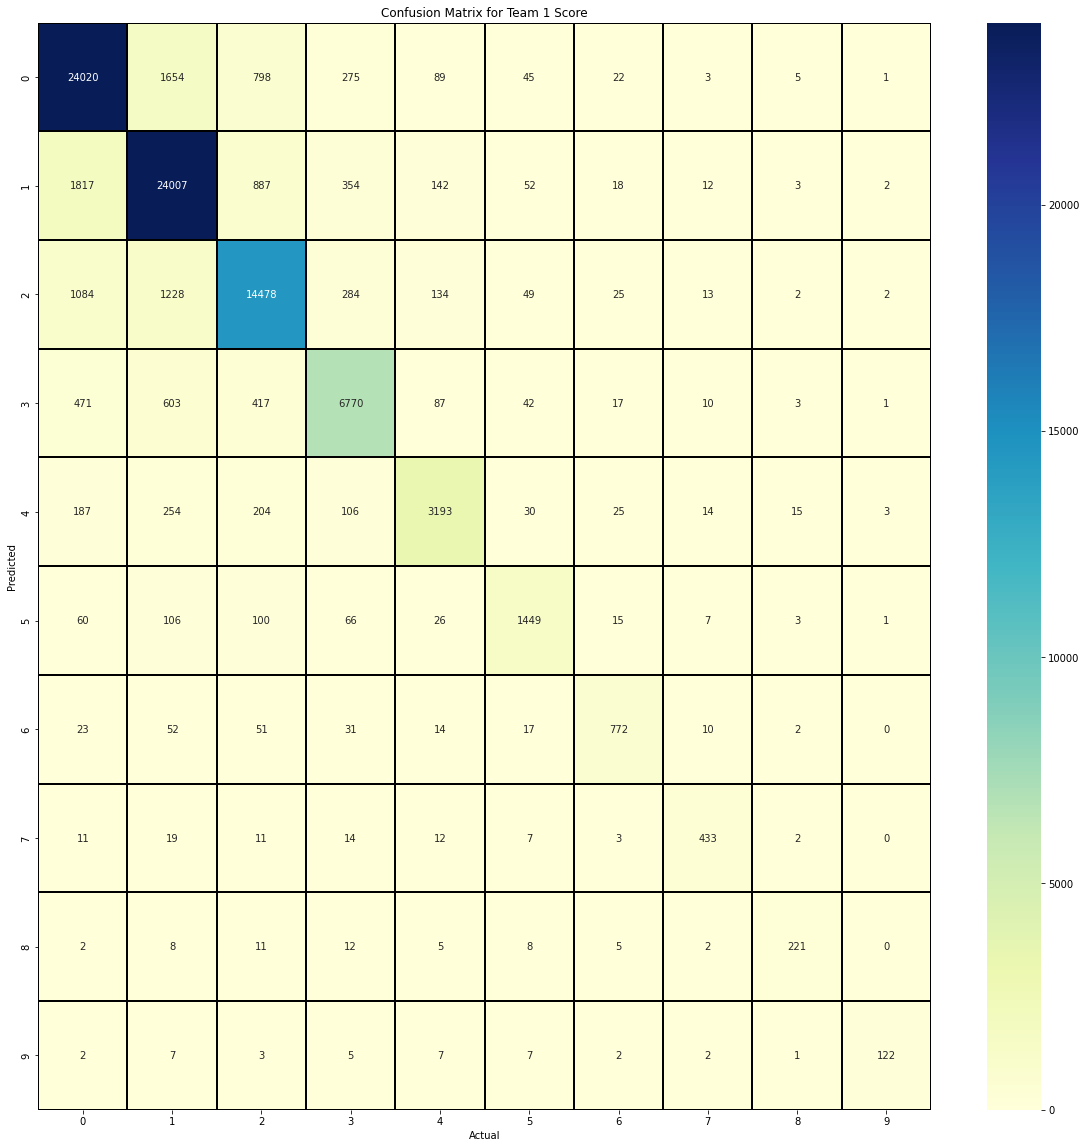

In [41]:
#Traçando a Matriz de Confusão para pontuação da equipe 01
plt.figure(figsize=(20,20))
sns.heatmap(cm1, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for Team 1 Score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [42]:
#Relatório de classificação para equipe 1 Pontuação
from sklearn.metrics import classification_report
report_1=classification_report(Y.iloc[:,0],score_team_1)
print(report_1)

#Tem uma boa Precisão em prever a pontuação da equipe 1

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     26912
         1.0       0.86      0.88      0.87     27294
         2.0       0.85      0.84      0.85     17299
         3.0       0.86      0.80      0.83      8421
         4.0       0.86      0.79      0.83      4031
         5.0       0.85      0.79      0.82      1833
         6.0       0.85      0.79      0.82       972
         7.0       0.86      0.85      0.85       512
         8.0       0.86      0.81      0.83       274
         9.0       0.92      0.77      0.84       158

    accuracy                           0.86     87706
   macro avg       0.86      0.82      0.84     87706
weighted avg       0.86      0.86      0.86     87706



Text(159.0, 0.5, 'Predicted')

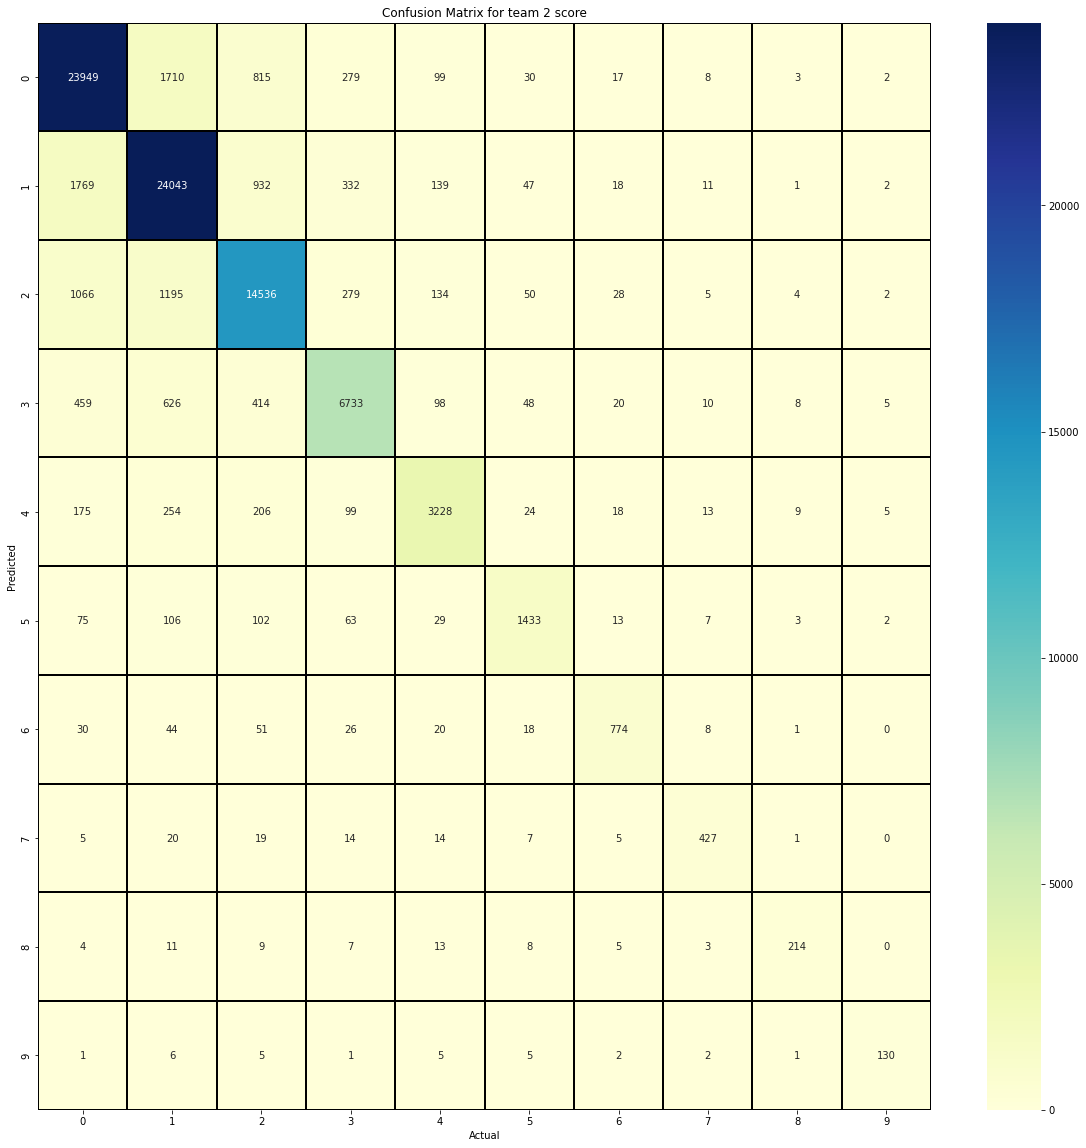

In [43]:
#Traçando a Matriz de Confusão para pontuação da equipe 02
plt.figure(figsize=(20,20))
sns.heatmap(cm2, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for team 2 score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [44]:
#Relatório de classificação para equipe 2 Pontuação
report_2=classification_report(Y.iloc[:,1],score_team_2)
print(report_2)

#Tem uma boa Precisão em prever a pontuação da equipe 1#

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     26912
         1.0       0.86      0.88      0.87     27294
         2.0       0.85      0.84      0.85     17299
         3.0       0.86      0.80      0.83      8421
         4.0       0.85      0.80      0.83      4031
         5.0       0.86      0.78      0.82      1833
         6.0       0.86      0.80      0.83       972
         7.0       0.86      0.83      0.85       512
         8.0       0.87      0.78      0.82       274
         9.0       0.88      0.82      0.85       158

    accuracy                           0.86     87706
   macro avg       0.86      0.82      0.84     87706
weighted avg       0.86      0.86      0.86     87706



In [45]:
#Função para selecionar a equipe vencedora para a matriz de previsão
def select_winning_team(probability_array):
    prob_lst=[round(probability_array[0][i],3) for i in range(2)]
    if (prob_lst[0]>prob_lst[1]):
        out=0
    elif (prob_lst[0]<prob_lst[1]):
        out=1
    elif (prob_lst[0]==prob_lst[1]):
        out=2
    return out,prob_lst

In [46]:
#Previsão de amostra
mactch_played=2015
team_1="Brazil"
team_2="Argentina"
stadium="Qatar"

team_lst=[team_1,team_2]
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
stadium_num=label_encoder.transform([stadium])[0]

print(f"Team 01 is {team_1} -{team_1_num}")
print(f"Team 02 is {team_2} -{team_2_num}")
print(f"Played in  {stadium} -{stadium_num}")

Team 01 is Brazil -41
Team 02 is Argentina -12
Played in  Qatar -241


In [47]:
#saída de previsão de amostra
X_feature=np.array([[mactch_played,stadium_num,team_1_num,team_2_num]])
res=model.predict(X_feature)
win,_=select_winning_team(res)
try:
    print(f"{team_1} vs {team_2} \n {team_lst[win]} wins 🏆⚽🎯\n")
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽⚽\n") 

Brazil vs Argentina 
 Argentina wins 🏆⚽🎯



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


WORLD CUP 2022

In [48]:
Group_A= ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B= ["England","Iran","United States","Wales"]
Group_C= ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D= ["France","Australia","Denmark","Nigeria"]
Group_E= ["Spain","Costa Rica","Germany","Japan"]
Group_F= ["Belgium","Canada","Morocco","Croatia"]
Group_G= ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H= ["Portugal","Ghana","Uruguay","South Korea"]
Groups={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,"Group F":Group_F,"Group G":Group_G,"Group H":Group_H}


In [49]:
#Inicializar parâmetros básicos
year=2022
stadium="Qatar"
stadium_num=label_encoder.transform([stadium])[0]
host_num=stadium_num

In [50]:
#Jogos da fase de grupos

Group_standings={}
for grp_name in list(Groups.keys()):
    print(f"{grp_name} Matches")
    probable_countries=Groups[grp_name]
    team_wins_dct={}
    goal_scored_dct={}
    goal_against_dct={}
    win_dct={}
    draw_dct={}
    lost_dct={}
    for i in range(len(probable_countries)):
        j=i+1
        team_1=probable_countries[i]
        team_1_num=label_encoder.transform([team_1])[0]
        team_wins=0
        while j<len((probable_countries)):
            team_2=probable_countries[j]
            team_2_num=label_encoder.transform([team_2])[0]
            team_lst=[team_1,team_2]
            Input_vector=np.array([[year,stadium_num,team_1_num,team_2_num]])
            res=model.predict(Input_vector)

            win,prob_lst=select_winning_team(res)
            goal_scored_dct[team_1] = goal_scored_dct.get(team_1,0)+prob_lst[0]
            goal_scored_dct[team_2] = goal_scored_dct.get(team_2,0)+prob_lst[1]

            goal_against_dct[team_1] = goal_against_dct.get(team_1,0)+prob_lst[1]
            goal_against_dct[team_2] = goal_against_dct.get(team_2,0)+prob_lst[0]

            try:
                print(f" {team_1} vs {team_2} \n  Results of the Match {res[0]}\n   {team_lst[win]} wins 🎊🏆⚽🎖️\n")
                if (win)==0:
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+2
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)
                    
                    win_dct[team_1] = win_dct.get(team_1,0)+1
                    win_dct[team_2] = win_dct.get(team_2,0)
                    lost_dct[team_2] = lost_dct.get(team_2,0)+1
                    lost_dct[team_1] = lost_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)

                elif (win)==1:
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+2
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)
                    
                    win_dct[team_2] = win_dct.get(team_2,0)+1
                    win_dct[team_1] = win_dct.get(team_1,0)
                    lost_dct[team_1] = lost_dct.get(team_1,0)+1
                    lost_dct[team_2] = lost_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)

            except IndexError:
                print(f"{team_1} vs {team_2} \n  Results of the Match {res[0]}\n   Match Draw ⚽⚽⚽\n") 
                team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+1
                team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+1
                
                draw_dct[team_1] = draw_dct.get(team_1,0)+1
                draw_dct[team_2] = draw_dct.get(team_2,0)+1
                
                win_dct[team_1] = win_dct.get(team_1,0)
                lost_dct[team_1] = lost_dct.get(team_1,0)
                
                win_dct[team_2] = win_dct.get(team_2,0)
                lost_dct[team_2] = lost_dct.get(team_2,0)
                    
            j=j+1
    group_results=[win_dct,draw_dct,lost_dct,team_wins_dct,goal_scored_dct,goal_against_dct]
    Group_standings[grp_name]=group_results

Group A Matches
 Qatar vs Ecuador 
  Results of the Match [1. 0.]
   Qatar wins 🎊🏆⚽🎖️

Qatar vs Senegal 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 Qatar vs Netherlands 
  Results of the Match [1. 0.]
   Qatar wins 🎊🏆⚽🎖️

Ecuador vs Senegal 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Ecuador vs Netherlands 
  Results of the Match [1. 0.]
   Ecuador wins 🎊🏆⚽🎖️

 Senegal vs Netherlands 
  Results of the Match [2. 0.]
   Senegal wins 🎊🏆⚽🎖️

Group B Matches
 England vs Iran 
  Results of the Match [0. 1.]
   Iran wins 🎊🏆⚽🎖️



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 England vs United States 
  Results of the Match [2. 1.]
   England wins 🎊🏆⚽🎖️

 England vs Wales 
  Results of the Match [2. 1.]
   England wins 🎊🏆⚽🎖️



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Iran vs United States 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Iran vs Wales 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

United States vs Wales 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Group C Matches
 Argentina vs Saudi Arabia 
  Results of the Match [1. 0.]
   Argentina wins 🎊🏆⚽🎖️

 Argentina vs Mexico 
  Results of the Match [1. 0.]
   Argentina wins 🎊🏆⚽🎖️

 Argentina vs Poland 
  Results of the Match [1. 0.]
   Argentina wins 🎊🏆⚽🎖️

Saudi Arabia vs Mexico 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Saudi Arabia vs Poland 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Mexico vs Poland 
  Results of the Match [1. 2.]
   Poland wins 🎊🏆⚽🎖️

Group D Matches


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

France vs Australia 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

France vs Denmark 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 France vs Nigeria 
  Results of the Match [2. 1.]
   France wins 🎊🏆⚽🎖️

Australia vs Denmark 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 Australia vs Nigeria 
  Results of the Match [2. 0.]
   Australia wins 🎊🏆⚽🎖️

 Denmark vs Nigeria 
  Results of the Match [1. 0.]
   Denmark wins 🎊🏆⚽🎖️

Group E Matches
Spain vs Costa Rica 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Spain vs Germany 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Spain vs Japan 
  Results of the Match [1. 0.]
   Spain wins 🎊🏆⚽🎖️

 Costa Rica vs Germany 
  Results of the Match [0. 1.]
   Germany wins 🎊🏆⚽🎖️

Costa Rica vs Japan 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 Germany vs Japan 
  Results of the Match [0. 1.]
   Japan wins 🎊🏆⚽🎖️

Group F Matches
 Belgium vs Canada 
  Results of the Match [0. 1.]
   Canada wins 🎊🏆⚽🎖️

 Belgium vs Morocco 
  Results of the Match [0. 1.]
   Morocco wins 🎊🏆⚽🎖️



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Belgium vs Croatia 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Canada vs Morocco 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Canada vs Croatia 
  Results of the Match [1. 0.]
   Canada wins 🎊🏆⚽🎖️

Morocco vs Croatia 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Group G Matches


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 Brazil vs Serbia 
  Results of the Match [1. 0.]
   Brazil wins 🎊🏆⚽🎖️

Brazil vs Switzerland 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Brazil vs Cameroon 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

 Serbia vs Switzerland 
  Results of the Match [1. 0.]
   Serbia wins 🎊🏆⚽🎖️

 Serbia vs Cameroon 
  Results of the Match [1. 0.]
   Serbia wins 🎊🏆⚽🎖️

 Switzerland vs Cameroon 
  Results of the Match [1. 0.]
   Switzerland wins 🎊🏆⚽🎖️

Group H Matches
Portugal vs Ghana 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Portugal vs Uruguay 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Portugal vs South Korea 
  Results of the Match [0. 1.]
   South Korea wins 🎊🏆⚽🎖️

Ghana vs Uruguay 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Ghana vs South Korea 
  Results of the Match [1. 0.]
   Ghana wins 🎊🏆⚽🎖️

 Uruguay vs South Korea 
  Results of the Match [1. 0.]
   Uruguay wins 🎊🏆⚽🎖️



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

In [51]:
#Exibir resultados da fase de grupos
for grp_name in list(Group_standings.keys()):

    team_wins_dct= dict(sorted(Group_standings[grp_name][3].items()))
    goal_scored_dct=dict(sorted(Group_standings[grp_name][4].items()))
    goal_against_dct=dict(sorted(Group_standings[grp_name][5].items()))
    
    win_dct=dict(sorted(Group_standings[grp_name][0].items()))
    draw_dct=dict(sorted(Group_standings[grp_name][1].items()))
    lost_dct=dict(sorted(Group_standings[grp_name][2].items()))
    
    lst_teams=list(team_wins_dct.keys())
    
    win_lst=list(win_dct.values())
    draw_lst=list(draw_dct.values())
    lost_lst=list(lost_dct.values())
    
    lst_win_count=list(team_wins_dct.values())
    goal_scored=list(goal_scored_dct.values())
    goal_against=list(goal_against_dct.values())
    goal_differance=[goal_scored[i]-goal_against[i] for i in range (len(goal_scored))]
    ranking_table=pd.DataFrame(list(zip(lst_teams,win_lst,draw_lst,lost_lst,goal_scored,goal_against,goal_differance,lst_win_count)),columns=["Team","Wins","Draw","Lost","Goal Scored","Goal Against","Goal Differance","Points"])
    ranking_table=ranking_table.sort_values("Points",ascending=False).reset_index(drop=True)
    ranking_table.index = ranking_table.index + 1
    print(f"\n\n{grp_name} Final Rankings")
    print(ranking_table.to_markdown())
    



Group A Final Rankings
|    | Team        |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | Qatar       |      2 |      1 |      0 |             3 |              1 |                 2 |        5 |
|  2 | Senegal     |      1 |      2 |      0 |             3 |              1 |                 2 |        4 |
|  3 | Ecuador     |      1 |      1 |      1 |             1 |              1 |                 0 |        3 |
|  4 | Netherlands |      0 |      0 |      3 |             0 |              4 |                -4 |        0 |


Group B Final Rankings
|    | Team          |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:--------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | England       |      2 |      0 |      1 | 

In [52]:
#Round of 16 Section_1
qualified_teams_1=[]
standings=list(Group_standings.keys())
i=0
print(f"Round of 16\n")
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[0][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[1][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(team_lst[win])
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(winning_team)
    i=i+2
    
##Round of 16 Section_2
qualified_teams_2=[]
standings=list(Group_standings.keys())
i=0
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[1][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[0][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(winning_team)
    i=i+2

Round of 16

Qatar vs England 
  Qatar wins 🏆🏆
    Qatar into the Quater-Finals ⏩⏩ 

Argentina vs Australia 
  Argentina wins 🏆🏆
    Argentina into the Quater-Finals ⏩⏩ 

Spain vs Morocco 
  Match Draw ⚽⚽
   Morocco wins at Penaly Shoot-Out 🥅🎯
    Morocco into the Quater-Finals ⏩⏩ 

Brazil vs Uruguay 
  Match Draw ⚽⚽
   Brazil wins at Penaly Shoot-Out 🥅🎯
    Brazil into the Quater-Finals ⏩⏩ 

Senegal vs Iran 
  Iran wins 🏆🏆
    Iran into the Quater-Finals ⏩⏩ 

Poland vs France 
  France wins 🏆🏆
    France into the Quater-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

Germany vs Canada 
  Canada wins 🏆🏆
    Canada into the Quater-Finals ⏩⏩ 

Serbia vs Ghana 
  Match Draw ⚽⚽
   Serbia wins at Penaly Shoot-Out 🥅🎯
    Serbia into the Quater-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [53]:
print(f"Teams selected to the Quater Finals - {qualified_teams_1+qualified_teams_2}")

Teams selected to the Quater Finals - ['Qatar', 'Argentina', 'Morocco', 'Brazil', 'Iran', 'France', 'Canada', 'Serbia']


In [54]:
#Quartas de final
Semifinal_teams=[]
i=0
print(f"Quater Final Matches\n")
while i < (len(qualified_teams_1))-1:
    team_1= qualified_teams_1[i]
    team_2= qualified_teams_1[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽")
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2
    
i=0
while i < (len(qualified_teams_2))-1:
    team_1= qualified_teams_2[i]
    team_2= qualified_teams_2[i+1]
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2

Quater Final Matches

Qatar vs Argentina 
  Match Draw ⚽⚽
   Qatar wins at Penaly Shoot-Out 🥅🎯
    Qatar into the Semi-Finals ⏩⏩ 

Morocco vs Brazil 
  Match Draw ⚽⚽
   Brazil wins at Penaly Shoot-Out 🥅🎯
    Brazil into the Semi-Finals ⏩⏩ 

Iran vs France 
  France wins 🏆🏆
    France into the Semi-Finals ⏩⏩ 

Canada vs Serbia 
  Canada wins 🏆🏆
    Canada into the Semi-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with

In [55]:
print(f"Teams selected to the Semi-Finals - {Semifinal_teams}")

Teams selected to the Semi-Finals - ['Qatar', 'Brazil', 'France', 'Canada']


In [56]:
#Semifinais
final_teams=[]
third_place_match_teams=[]
i=0
print(f"Semi Final Matches\n")
while i < (len(Semifinal_teams))-1:
    team_1= Semifinal_teams[i]
    team_2= Semifinal_teams[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the FiIFA-Finals ⏩⏩ \n")
            final_teams.append(team_lst[win])
            third_place_match_teams.append(team_lst[(win+1)%2])

            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the FIFA-Finals ⏩⏩ \n")
            final_teams.append(winning_team)
            team_lst.remove(winning_team)
            third_place_match_teams.append(team_lst[0])
    i=i+2
    

Semi Final Matches



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Qatar vs Brazil 
  Match Draw ⚽⚽
   Qatar wins at Penaly Shoot-Out 🥅🎯
    Qatar into the FIFA-Finals ⏩⏩ 

France vs Canada 
  Match Draw ⚽⚽
   Canada wins at Penaly Shoot-Out 🥅🎯
    Canada into the FIFA-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


###FINAL

In [57]:
print(f"Teams selected to the Finals - {final_teams}")
print(f"Teams selected to the Third Place match - {third_place_match_teams}")

Teams selected to the Finals - ['Qatar', 'Canada']
Teams selected to the Third Place match - ['Brazil', 'France']


In [58]:
#Finais e disputa do terceiro lugar
print(f"FiIFA FINAl\n")
team_1= final_teams[1]
team_2= final_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} are the Winners 🎉🏆🎉\n\n")
    winner=team_lst[win]
    place_2=team_lst[(win+1)%2]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} are the Winners 🎉🏆🎉\n\n")
    winner=winning_team
    
    team_lst.remove(winning_team)
    place_2=team_lst[0]

print(f"Third Place match\n")
team_1= third_place_match_teams[1]
team_2= third_place_match_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=team_lst[win]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=winning_team
    

    
print(f"\n\nWinner is {winner} 🥇🥇🥇")
print(f"Runner-up is {place_2} 🥈🥈🥈")
print(f"3rd Place is {place_3} 🥉🥉🥉")

FiIFA FINAl

Canada vs Qatar 
  Canada are the Winners 🎉🏆🎉


Third Place match

France vs Brazil 
  Brazil Wins the 3rd Place 🎉🏆🎉



Winner is Canada 🥇🥇🥇
Runner-up is Qatar 🥈🥈🥈
3rd Place is Brazil 🥉🥉🥉


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


##SIMULATOR_3

###DATA PREPARATION

In [59]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
from IPython.display import Image
random_num=122

In [60]:
df = pd.read_csv('/content/results.csv')
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
44147,2022-12-01,Canada,Morocco,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44148,2022-12-02,Serbia,Switzerland,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44149,2022-12-02,Cameroon,Brazil,NaN,NaN,FIFA World Cup,Lusail,Qatar,True
44150,2022-12-02,Ghana,Uruguay,NaN,NaN,FIFA World Cup,Al Wakrah,Qatar,True


In [61]:
df.describe()

,home_score,away_score
count,44104.000000,44104.000000
mean,1.740046,1.178102
std,1.747194,1.394679
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [62]:
df.isnull().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [63]:
##Suponha que o máximo de gols que um time pode marcar é 15

higher_home=10
higher_away=10
df=df[(df["home_score"]<higher_home) & (df["away_score"]<higher_away)]
df.head(5)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [64]:
#Criando uma nova coluna chamada "Win_Statues" para armazenar o resultado (Vitória, Perda, Empate) do time da casa

conditions  = [df["home_score"] ==df["away_score"], df["home_score"] > df["away_score"] , df["home_score"] < df["away_score"]]
choices     = [ "Draw", 'Win', 'Lost' ]
df["Win_Statues"] = np.select(conditions, choices)
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win


In [65]:
#Veja quais são os Países no conjunto de dados

countries=df.home_team.unique()
print(f"There are {len(countries)} Countries in the home_team Column\n")
print(f"Countries-{countries}")

There are 307 Countries in the home_team Column

Countries-['Scotland' 'England' 'Wales' 'Northern Ireland' 'United States' 'Uruguay'
 'Austria' 'Hungary' 'Argentina' 'Belgium' 'France' 'Netherlands'
 'Czechoslovakia' 'Switzerland' 'Germany' 'Italy' 'Chile' 'Norway'
 'Sweden' 'Finland' 'Luxembourg' 'Russia' 'Denmark' 'Catalonia'
 'Basque Country' 'Brazil' 'Paraguay' 'Japan' 'Canada' 'Estonia'
 'Costa Rica' 'Guatemala' 'Spain' 'Brittany' 'Poland' 'Yugoslavia'
 'New Zealand' 'Romania' 'Latvia' 'Galicia' 'Portugal' 'Andalusia'
 'China PR' 'Australia' 'Lithuania' 'Turkey' 'Central Spain' 'Mexico'
 'Aruba' 'Haiti' 'Philippines' 'Bulgaria' 'Jamaica' 'Kenya' 'Bolivia'
 'Peru' 'Honduras' 'Guyana' 'Uganda' 'Belarus' 'El Salvador' 'Barbados'
 'Republic of Ireland' 'Trinidad and Tobago' 'Greece' 'Curaçao' 'Egypt'
 'Dominica' 'Silesia' 'Guadeloupe' 'Israel' 'Suriname' 'French Guiana'
 'Cuba' 'Colombia' 'Ecuador' 'Saint Kitts and Nevis' 'Panama' 'Slovakia'
 'Manchukuo' 'Croatia' 'Nicaragua' 'Afghan

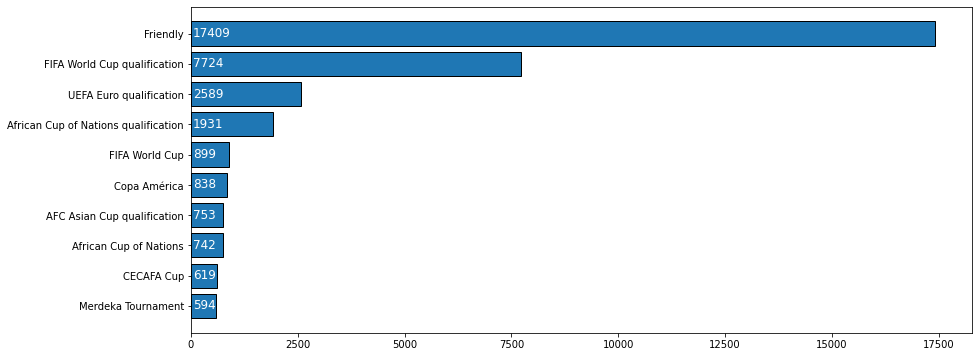

In [66]:
#Tipo de partidas
rank_bound = 10
ax = df.tournament.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

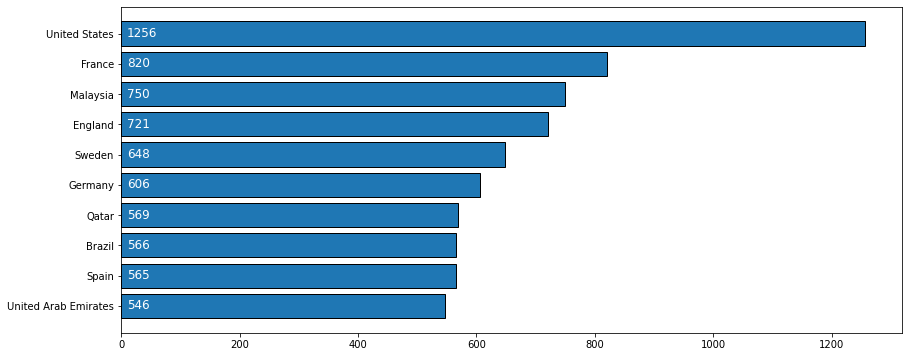

In [67]:
#As equipes jogaram a maioria das partidas
rank_bound = 10
ax = df.country.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=10,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

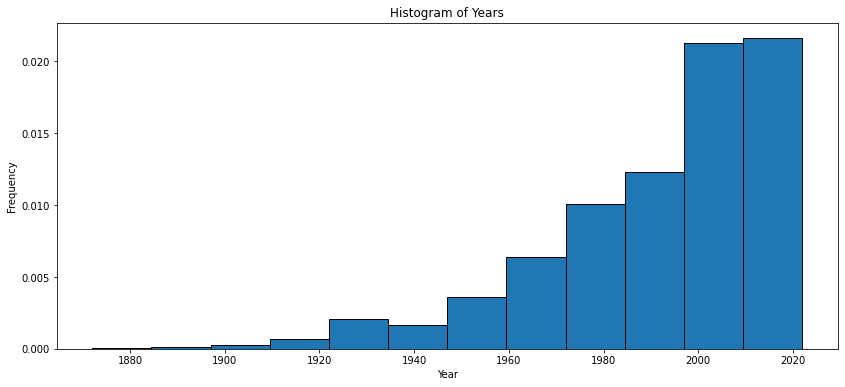

In [68]:
#Número de partidas disputadas em intervalos iguais

years = []
for date in df.date:
    years.append(int(str(date)[0:4]))
plt.figure(figsize=(14,6))
plt.hist(years, density=True, bins=12, edgecolor="k")
plt.title("Histogram of Years")
plt.ylabel("Frequency")
plt.xlabel("Year")
plt.show()

In [69]:
#Descobrir o impacto de sediar um grande torneio ajuda nas chances de vitória de um país?
#Agora pegue os rpws que home_team==Country
#Nad romover os dados dos amistosos

data_home=df.loc[df["home_team"]==df["country"] ]
data_home=df.loc[df["tournament"] != "Friendly"]
data_home.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
29,1884-01-26,Northern Ireland,Scotland,0.0,5.0,British Championship,Belfast,Ireland,False,Lost
30,1884-02-09,Wales,Northern Ireland,6.0,0.0,British Championship,Wrexham,Wales,False,Win
31,1884-02-23,Northern Ireland,England,1.0,8.0,British Championship,Belfast,Ireland,False,Lost
32,1884-03-15,Scotland,England,1.0,0.0,British Championship,Glasgow,Scotland,False,Win
33,1884-03-17,Wales,England,0.0,4.0,British Championship,Wrexham,Wales,False,Lost


In [70]:
# Estatísticas de vitórias do time da casa
#Como o time da casa se sai nas partidas do torneio

tournament_df=pd.crosstab(data_home["tournament"], data_home["Win_Statues"],margins=True)
tournament_df=tournament_df.sort_values("All",ascending=False).head(10)
tournament_df.style.bar(color="brown",subset=["Draw","Lost","Win","All"])

Win_Statues,Draw,Lost,Win,All
tournament,,,,
All,5791,7540,13113,26444
FIFA World Cup qualification,1644,2124,3956,7724
UEFA Euro qualification,510,817,1262,2589
African Cup of Nations qualification,472,378,1081,1931
FIFA World Cup,199,290,410,899
Copa América,181,230,427,838
AFC Asian Cup qualification,126,188,439,753
African Cup of Nations,209,200,333,742
CECAFA Cup,147,185,287,619


Text(0.5, 1.0, 'Home Team Winning Status')

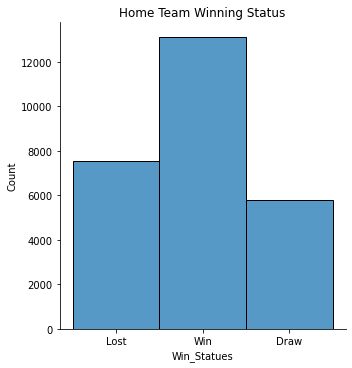

In [71]:
# Resultados do time da casa
sns.displot(data_home, x="Win_Statues")
plt.title("Home Team Winning Status")

In [72]:
data_home['Win_Statues'].value_counts()

Win     13113
Lost     7540
Draw     5791
Name: Win_Statues, dtype: int64

In [73]:
#Como cada equipe se sai durante um torneio em casa

teams_win_statues=pd.crosstab(df["home_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_win_statues["team_win_probability"]=teams_win_statues["Win"]/(teams_win_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_win_statues_100=teams_win_statues.loc[teams_win_statues["Total"]>50]
teams_win_statues_100=teams_win_statues_100.sort_values("team_win_probability",ascending=False)
teams_win_statues_100.head(20).style.bar(color="orange",subset="team_win_probability")

#Podemos ver que as equipes têm mais de 50% de probabilidade de vitória jogando em casa

Win_Statues,Draw,Lost,Win,Total,team_win_probability
home_team,,,,,
Brazil,110,58,422,590,0.715254
Spain,70,51,253,374,0.676471
Argentina,124,68,371,563,0.658970
Czech Republic,20,36,104,160,0.650000
Ivory Coast,67,35,183,285,0.642105
Egypt,69,74,256,399,0.641604
North Korea,23,22,79,124,0.637097
Nigeria,69,36,184,289,0.636678
Iran,63,44,184,291,0.632302


In [74]:
# Estatísticas de vitórias do time visitante
#Equipes jogando fora de casa

teams_away_statues=pd.crosstab(df["away_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_away_statues["team_win_probability"]=teams_away_statues["Lost"]/(teams_away_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_away_statues_100=teams_away_statues.loc[teams_away_statues["Total"]>50]
teams_away_statues_100=teams_away_statues_100.sort_values("team_win_probability",ascending=False)
teams_away_statues_100.rename(columns={'Lost': 'Win'}, index={'Win': 'Lost'}, inplace=True)
teams_away_statues_100.head(20)

#A probabilidade de ganhar um torneio fora de casa é muito baixa em comparação com as probabilidades de ganhar em casa

Win_Statues,Draw,Win,Win,Total,team_win_probability
away_team,,,,,
Brazil,95,228,102,425,0.536471
Germany,93,245,119,457,0.536105
England,136,265,117,518,0.511583
Spain,100,168,83,351,0.478632
Tahiti,16,50,43,109,0.458716
Croatia,49,83,50,182,0.456044
Iran,67,101,57,225,0.448889
South Korea,114,181,109,404,0.448020
Netherlands,83,167,129,379,0.440633


In [75]:
teams_away_statues_100["team_win_probability"]

away_team
Brazil           0.536471
Germany          0.536105
England          0.511583
Spain            0.478632
Tahiti           0.458716
                   ...   
Somalia          0.060606
Liechtenstein    0.058824
Seychelles       0.042254
Andorra          0.021505
San Marino       0.000000
Name: team_win_probability, Length: 198, dtype: float64

In [76]:
#fazendo uma cópia do dataframe principal para uso futuro
df_match=df.copy() 
df_match.head(8)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,Win
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,Lost
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,Lost


In [77]:
#Criando um novo conjunto de dados com os recursos necessários para treinar o modelo de aprendizado de máquina
#Ano,País Jogado,Team_1,team_2,pontuação do time_1,pontuação do time_2
New_Dataset_part_1=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,1],df_match.values[:,2],df_match.values[:,3],df_match.values[:,4])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])

#Criando um novo dataset alterando team_1 e team_2 e suas respectivas pontuações
New_Dataset_part_2=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,2],df_match.values[:,1],df_match.values[:,4],df_match.values[:,3])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])
New_Dataset=pd.concat([New_Dataset_part_1,New_Dataset_part_2],axis=0)
New_Dataset =New_Dataset.sample(frac=1).reset_index(drop=True) #Shaffling the dataset
New_Dataset.head(5)

,year,Country,team_1,team_2,team_1_score,team_2_score
0,1931,Yugoslavia,Romania,Yugoslavia,4.0,2.0
1,1977,Tanzania,Mozambique,Tanzania,1.0,2.0
2,1922,Austria,Switzerland,Austria,1.0,7.0
3,2021,DR Congo,Benin,DR Congo,0.0,2.0
4,2000,China PR,Thailand,Uzbekistan,4.0,2.0


In [78]:
#Criando uma lista contendo todos os nomes dos países
teams_1=New_Dataset.team_1.unique()
contries=New_Dataset.Country.unique()
all_countries=np.unique(np.concatenate((teams_1,contries), axis=0))
len(all_countries)

349

,year,team_1_score,team_2_score
year,1.000000,-0.128843,-0.128843
team_1_score,-0.128843,1.000000,-0.156674
team_2_score,-0.128843,-0.156674,1.000000


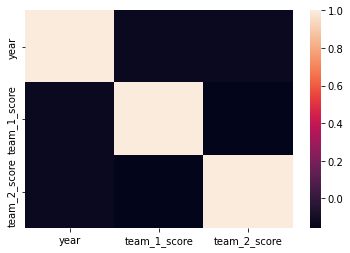

In [79]:
#Fazendo um mapa de calor para ver a correlação de cada coluna
sns.heatmap(New_Dataset.corr())
New_Dataset.corr()

In [80]:
#Definindo as features e labels(Targets)
Y= New_Dataset.iloc[:,4:6]                                                      # Metas de treinamento (team_1_score e team_2_score)
categorized_data=New_Dataset.iloc[:,0:4].copy()                                 # Recursos de treinamento

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

#Rotulando os dados usando LabelEncorder no Sklearn-(Dando um número único para cada string(país))
label_encoder.fit(all_countries)

#list(label_encoder.classes_)
categorized_data['team_1']=label_encoder.transform(categorized_data['team_1'])
categorized_data['team_2']=label_encoder.transform(categorized_data['team_2'])
categorized_data['Country']=label_encoder.transform(categorized_data['Country'])

#Convertendo essas colunas de recursos para categorizar o formulário para tornar o processo de treinamento mais suave
categorized_data['team_1']=categorized_data['team_1'].astype("category")
categorized_data['team_2']=categorized_data['team_2'].astype("category")
categorized_data['Country']=categorized_data['team_2'].astype("category")

In [81]:
#Características de entrada para o modelo (x)
categorized_data.head(5)

,year,Country,team_1,team_2
0,1931,342,248,342
1,1977,300,200,300
2,1922,18,290,18
3,2021,81,31,81
4,2000,322,301,322


In [82]:
Y.head(5)

,team_1_score,team_2_score
0,4.0,2.0
1,1.0,2.0
2,1.0,7.0
3,0.0,2.0
4,4.0,2.0


In [83]:
#Informações sobre os dataframes X e Y
print(categorized_data.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   year     87706 non-null  int64   
 1   Country  87706 non-null  category
 2   team_1   87706 non-null  category
 3   team_2   87706 non-null  category
dtypes: category(3), int64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team_1_score  87706 non-null  float64
 1   team_2_score  87706 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


In [84]:
#Fazendo o modelo
X=categorized_data
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [85]:
#Use qualquer algoritmo
model = MultiOutputRegressor(LogisticRegression())
model.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


MultiOutputRegressor(estimator=LogisticRegression())

In [86]:
#Fazendo as previsões
prd=model.predict(X)
prd

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 1.],
       [1., 1.]])

In [87]:
#Criando a matriz de confusão para cada previsão
score_team_1=[i[0] for i in prd]
score_team_2=[i[1] for i in prd]

from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(list(Y.iloc[:,0]),score_team_1)
cm2=confusion_matrix(list(Y.iloc[:,1]),score_team_2)

Text(159.0, 0.5, 'Predicted')

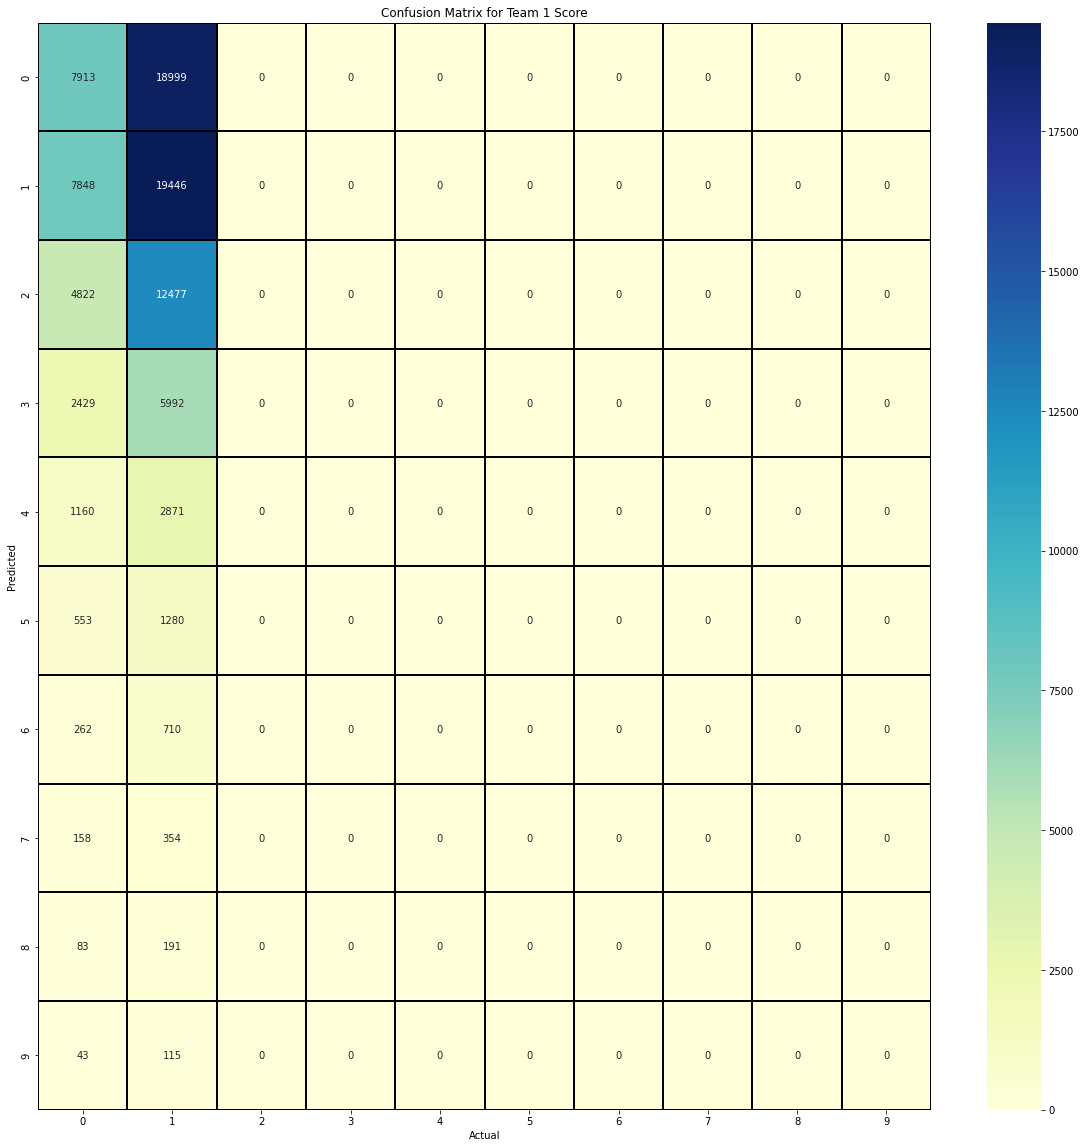

In [88]:
#Traçando a Matriz de Confusão para pontuação da equipe 01
plt.figure(figsize=(20,20))
sns.heatmap(cm1, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for Team 1 Score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [89]:
#Relatório de classificação para equipe 1 Pontuação
from sklearn.metrics import classification_report
report_1=classification_report(Y.iloc[:,0],score_team_1)
print(report_1)

#Tem uma boa Precisão em prever a pontuação da equipe 1

              precision    recall  f1-score   support

         0.0       0.31      0.29      0.30     26912
         1.0       0.31      0.71      0.43     27294
         2.0       0.00      0.00      0.00     17299
         3.0       0.00      0.00      0.00      8421
         4.0       0.00      0.00      0.00      4031
         5.0       0.00      0.00      0.00      1833
         6.0       0.00      0.00      0.00       972
         7.0       0.00      0.00      0.00       512
         8.0       0.00      0.00      0.00       274
         9.0       0.00      0.00      0.00       158

    accuracy                           0.31     87706
   macro avg       0.06      0.10      0.07     87706
weighted avg       0.19      0.31      0.23     87706



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(159.0, 0.5, 'Predicted')

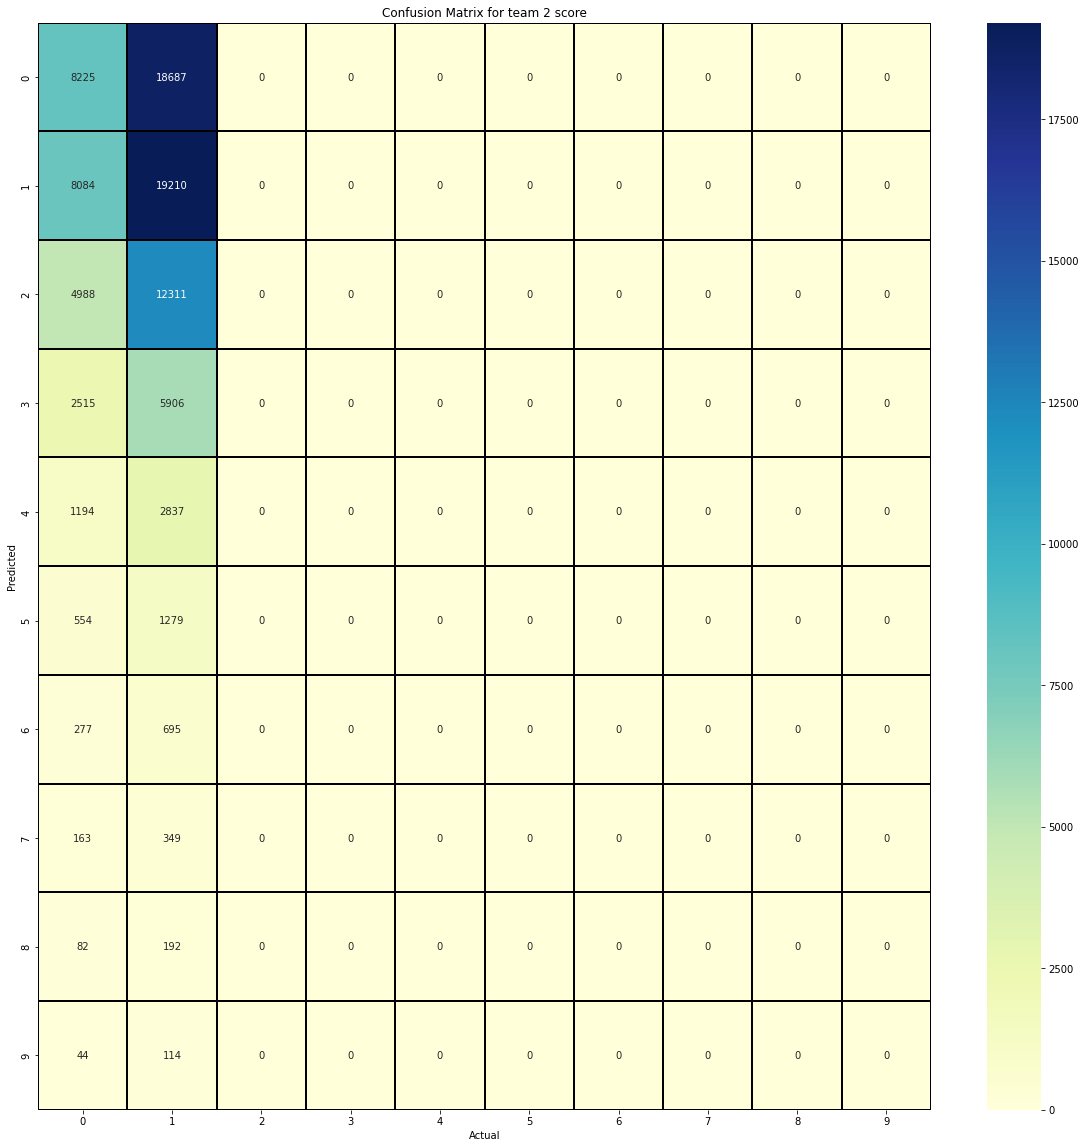

In [90]:
#Traçando a Matriz de Confusão para pontuação da equipe 02
plt.figure(figsize=(20,20))
sns.heatmap(cm2, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for team 2 score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [91]:
#Relatório de classificação para equipe 2 Pontuação
report_2=classification_report(Y.iloc[:,1],score_team_2)
print(report_2)

#Tem uma boa Precisão em prever a pontuação da equipe 1#

              precision    recall  f1-score   support

         0.0       0.31      0.31      0.31     26912
         1.0       0.31      0.70      0.43     27294
         2.0       0.00      0.00      0.00     17299
         3.0       0.00      0.00      0.00      8421
         4.0       0.00      0.00      0.00      4031
         5.0       0.00      0.00      0.00      1833
         6.0       0.00      0.00      0.00       972
         7.0       0.00      0.00      0.00       512
         8.0       0.00      0.00      0.00       274
         9.0       0.00      0.00      0.00       158

    accuracy                           0.31     87706
   macro avg       0.06      0.10      0.07     87706
weighted avg       0.19      0.31      0.23     87706



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
#Função para selecionar a equipe vencedora para a matriz de previsão
def select_winning_team(probability_array):
    prob_lst=[round(probability_array[0][i],3) for i in range(2)]
    if (prob_lst[0]>prob_lst[1]):
        out=0
    elif (prob_lst[0]<prob_lst[1]):
        out=1
    elif (prob_lst[0]==prob_lst[1]):
        out=2
    return out,prob_lst

In [93]:
#Previsão de amostra
mactch_played=2015
team_1="Brazil"
team_2="Argentina"
stadium="Qatar"

team_lst=[team_1,team_2]
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
stadium_num=label_encoder.transform([stadium])[0]

print(f"Team 01 is {team_1} -{team_1_num}")
print(f"Team 02 is {team_2} -{team_2_num}")
print(f"Played in  {stadium} -{stadium_num}")

Team 01 is Brazil -41
Team 02 is Argentina -12
Played in  Qatar -241


In [94]:
#saída de previsão de amostra
X_feature=np.array([[mactch_played,stadium_num,team_1_num,team_2_num]])
res=model.predict(X_feature)
win,_=select_winning_team(res)
try:
    print(f"{team_1} vs {team_2} \n {team_lst[win]} wins 🏆⚽🎯\n")
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽⚽\n") 

Brazil vs Argentina 
  Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


WORLD CUP 2022

In [95]:
Group_A= ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B= ["England","Iran","United States","Wales"]
Group_C= ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D= ["France","Australia","Denmark","Nigeria"]
Group_E= ["Spain","Costa Rica","Germany","Japan"]
Group_F= ["Belgium","Canada","Morocco","Croatia"]
Group_G= ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H= ["Portugal","Ghana","Uruguay","South Korea"]
Groups={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,"Group F":Group_F,"Group G":Group_G,"Group H":Group_H}


In [96]:
#Inicializar parâmetros básicos
year=2022
stadium="Qatar"
stadium_num=label_encoder.transform([stadium])[0]
host_num=stadium_num

In [97]:
#Jogos da fase de grupos

Group_standings={}
for grp_name in list(Groups.keys()):
    print(f"{grp_name} Matches")
    probable_countries=Groups[grp_name]
    team_wins_dct={}
    goal_scored_dct={}
    goal_against_dct={}
    win_dct={}
    draw_dct={}
    lost_dct={}
    for i in range(len(probable_countries)):
        j=i+1
        team_1=probable_countries[i]
        team_1_num=label_encoder.transform([team_1])[0]
        team_wins=0
        while j<len((probable_countries)):
            team_2=probable_countries[j]
            team_2_num=label_encoder.transform([team_2])[0]
            team_lst=[team_1,team_2]
            Input_vector=np.array([[year,stadium_num,team_1_num,team_2_num]])
            res=model.predict(Input_vector)

            win,prob_lst=select_winning_team(res)
            goal_scored_dct[team_1] = goal_scored_dct.get(team_1,0)+prob_lst[0]
            goal_scored_dct[team_2] = goal_scored_dct.get(team_2,0)+prob_lst[1]

            goal_against_dct[team_1] = goal_against_dct.get(team_1,0)+prob_lst[1]
            goal_against_dct[team_2] = goal_against_dct.get(team_2,0)+prob_lst[0]

            try:
                print(f" {team_1} vs {team_2} \n  Results of the Match {res[0]}\n   {team_lst[win]} wins 🎊🏆⚽🎖️\n")
                if (win)==0:
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+2
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)
                    
                    win_dct[team_1] = win_dct.get(team_1,0)+1
                    win_dct[team_2] = win_dct.get(team_2,0)
                    lost_dct[team_2] = lost_dct.get(team_2,0)+1
                    lost_dct[team_1] = lost_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)

                elif (win)==1:
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+2
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)
                    
                    win_dct[team_2] = win_dct.get(team_2,0)+1
                    win_dct[team_1] = win_dct.get(team_1,0)
                    lost_dct[team_1] = lost_dct.get(team_1,0)+1
                    lost_dct[team_2] = lost_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)

            except IndexError:
                print(f"{team_1} vs {team_2} \n  Results of the Match {res[0]}\n   Match Draw ⚽⚽⚽\n") 
                team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+1
                team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+1
                
                draw_dct[team_1] = draw_dct.get(team_1,0)+1
                draw_dct[team_2] = draw_dct.get(team_2,0)+1
                
                win_dct[team_1] = win_dct.get(team_1,0)
                lost_dct[team_1] = lost_dct.get(team_1,0)
                
                win_dct[team_2] = win_dct.get(team_2,0)
                lost_dct[team_2] = lost_dct.get(team_2,0)
                    
            j=j+1
    group_results=[win_dct,draw_dct,lost_dct,team_wins_dct,goal_scored_dct,goal_against_dct]
    Group_standings[grp_name]=group_results

Group A Matches
Qatar vs Ecuador 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Qatar vs Senegal 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Qatar vs Netherlands 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Ecuador vs Senegal 
  Results of the Match [0. 1.]
   Senegal wins 🎊🏆⚽🎖️

 Ecuador vs Netherlands 
  Results of the Match [0. 1.]
   Netherlands wins 🎊🏆⚽🎖️

Senegal vs Netherlands 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Group B Matches
 England vs Iran 
  Results of the Match [0. 1.]
   Iran wins 🎊🏆⚽🎖️

 England vs United States 
  Results of the Match [0. 1.]
   United States wins 🎊🏆⚽🎖️

 England vs Wales 
  Results of the Match [0. 1.]
   Wales wins 🎊🏆⚽🎖️

 Iran vs United States 
  Results of the Match [0. 1.]
   United States wins 🎊🏆⚽🎖️

 Iran vs Wales 
  Results of the Match [0. 1.]
   Wales wins 🎊🏆⚽🎖️

United States vs Wales 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Group C Matches
 Argentina vs Saudi Arabia 
  Results of the Match [0. 1.]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X 

Group H Matches
Portugal vs Ghana 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Portugal vs Uruguay 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Portugal vs South Korea 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Ghana vs Uruguay 
  Results of the Match [0. 1.]
   Uruguay wins 🎊🏆⚽🎖️

 Ghana vs South Korea 
  Results of the Match [0. 1.]
   South Korea wins 🎊🏆⚽🎖️

Uruguay vs South Korea 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽



In [98]:
#Exibir resultados da fase de grupos
for grp_name in list(Group_standings.keys()):

    team_wins_dct= dict(sorted(Group_standings[grp_name][3].items()))
    goal_scored_dct=dict(sorted(Group_standings[grp_name][4].items()))
    goal_against_dct=dict(sorted(Group_standings[grp_name][5].items()))
    
    win_dct=dict(sorted(Group_standings[grp_name][0].items()))
    draw_dct=dict(sorted(Group_standings[grp_name][1].items()))
    lost_dct=dict(sorted(Group_standings[grp_name][2].items()))
    
    lst_teams=list(team_wins_dct.keys())
    
    win_lst=list(win_dct.values())
    draw_lst=list(draw_dct.values())
    lost_lst=list(lost_dct.values())
    
    lst_win_count=list(team_wins_dct.values())
    goal_scored=list(goal_scored_dct.values())
    goal_against=list(goal_against_dct.values())
    goal_differance=[goal_scored[i]-goal_against[i] for i in range (len(goal_scored))]
    ranking_table=pd.DataFrame(list(zip(lst_teams,win_lst,draw_lst,lost_lst,goal_scored,goal_against,goal_differance,lst_win_count)),columns=["Team","Wins","Draw","Lost","Goal Scored","Goal Against","Goal Differance","Points"])
    ranking_table=ranking_table.sort_values("Points",ascending=False).reset_index(drop=True)
    ranking_table.index = ranking_table.index + 1
    print(f"\n\n{grp_name} Final Rankings")
    print(ranking_table.to_markdown())
    



Group A Final Rankings
|    | Team        |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | Netherlands |      1 |      2 |      0 |             3 |              2 |                 1 |        4 |
|  2 | Senegal     |      1 |      2 |      0 |             3 |              2 |                 1 |        4 |
|  3 | Qatar       |      0 |      3 |      0 |             3 |              3 |                 0 |        3 |
|  4 | Ecuador     |      0 |      1 |      2 |             1 |              3 |                -2 |        1 |


Group B Final Rankings
|    | Team          |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:--------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | United States |      2 |      1 |      0 | 

In [99]:
#Round of 16 Section_1
qualified_teams_1=[]
standings=list(Group_standings.keys())
i=0
print(f"Round of 16\n")
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[0][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[1][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(team_lst[win])
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(winning_team)
    i=i+2
    
##Round of 16 Section_2
qualified_teams_2=[]
standings=list(Group_standings.keys())
i=0
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[1][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[0][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(winning_team)
    i=i+2

Round of 16

Senegal vs Wales 
  Match Draw ⚽⚽
   Wales wins at Penaly Shoot-Out 🥅🎯
    Wales into the Quater-Finals ⏩⏩ 

Saudi Arabia vs Denmark 
  Saudi Arabia wins 🏆🏆
    Saudi Arabia into the Quater-Finals ⏩⏩ 

Spain vs Croatia 
  Spain wins 🏆🏆
    Spain into the Quater-Finals ⏩⏩ 

Serbia vs South Korea 
  Match Draw ⚽⚽
   Serbia wins at Penaly Shoot-Out 🥅🎯
    Serbia into the Quater-Finals ⏩⏩ 

Netherlands vs United States 
  Match Draw ⚽⚽
   Netherlands wins at Penaly Shoot-Out 🥅🎯
    Netherlands into the Quater-Finals ⏩⏩ 

Mexico vs Nigeria 
  Match Draw ⚽⚽
   Mexico wins at Penaly Shoot-Out 🥅🎯
    Mexico into the Quater-Finals ⏩⏩ 

Germany vs Morocco 
  Morocco wins 🏆🏆
    Morocco into the Quater-Finals ⏩⏩ 

Switzerland vs Uruguay 
  Match Draw ⚽⚽
   Uruguay wins at Penaly Shoot-Out 🥅🎯
    Uruguay into the Quater-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X 

In [100]:
print(f"Teams selected to the Quater Finals - {qualified_teams_1+qualified_teams_2}")

Teams selected to the Quater Finals - ['Wales', 'Saudi Arabia', 'Spain', 'Serbia', 'Netherlands', 'Mexico', 'Morocco', 'Uruguay']


In [101]:
#Quartas de final
Semifinal_teams=[]
i=0
print(f"Quater Final Matches\n")
while i < (len(qualified_teams_1))-1:
    team_1= qualified_teams_1[i]
    team_2= qualified_teams_1[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽")
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2
    
i=0
while i < (len(qualified_teams_2))-1:
    team_1= qualified_teams_2[i]
    team_2= qualified_teams_2[i+1]
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2

Quater Final Matches

Wales vs Saudi Arabia 
  Match Draw ⚽⚽
   Saudi Arabia wins at Penaly Shoot-Out 🥅🎯
    Saudi Arabia into the Semi-Finals ⏩⏩ 

Spain vs Serbia 
  Match Draw ⚽⚽
   Serbia wins at Penaly Shoot-Out 🥅🎯
    Serbia into the Semi-Finals ⏩⏩ 

Netherlands vs Mexico 
  Match Draw ⚽⚽
   Netherlands wins at Penaly Shoot-Out 🥅🎯
    Netherlands into the Semi-Finals ⏩⏩ 

Morocco vs Uruguay 
  Uruguay wins 🏆🏆
    Uruguay into the Semi-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X 

In [102]:
print(f"Teams selected to the Semi-Finals - {Semifinal_teams}")

Teams selected to the Semi-Finals - ['Saudi Arabia', 'Serbia', 'Netherlands', 'Uruguay']


In [103]:
#Semifinais
final_teams=[]
third_place_match_teams=[]
i=0
print(f"Semi Final Matches\n")
while i < (len(Semifinal_teams))-1:
    team_1= Semifinal_teams[i]
    team_2= Semifinal_teams[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the FiIFA-Finals ⏩⏩ \n")
            final_teams.append(team_lst[win])
            third_place_match_teams.append(team_lst[(win+1)%2])

            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the FIFA-Finals ⏩⏩ \n")
            final_teams.append(winning_team)
            team_lst.remove(winning_team)
            third_place_match_teams.append(team_lst[0])
    i=i+2
    

Semi Final Matches

Saudi Arabia vs Serbia 
  Match Draw ⚽⚽
   Saudi Arabia wins at Penaly Shoot-Out 🥅🎯
    Saudi Arabia into the FIFA-Finals ⏩⏩ 

Netherlands vs Uruguay 
  Uruguay wins 🏆🏆
    Uruguay into the FiIFA-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


###FINAL

In [104]:
print(f"Teams selected to the Finals - {final_teams}")
print(f"Teams selected to the Third Place match - {third_place_match_teams}")

Teams selected to the Finals - ['Saudi Arabia', 'Uruguay']
Teams selected to the Third Place match - ['Serbia', 'Netherlands']


In [105]:
#Finais e disputa do terceiro lugar
print(f"FiIFA FINAl\n")
team_1= final_teams[1]
team_2= final_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} are the Winners 🎉🏆🎉\n\n")
    winner=team_lst[win]
    place_2=team_lst[(win+1)%2]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} are the Winners 🎉🏆🎉\n\n")
    winner=winning_team
    
    team_lst.remove(winning_team)
    place_2=team_lst[0]

print(f"Third Place match\n")
team_1= third_place_match_teams[1]
team_2= third_place_match_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=team_lst[win]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=winning_team
    

    
print(f"\n\nWinner is {winner} 🥇🥇🥇")
print(f"Runner-up is {place_2} 🥈🥈🥈")
print(f"3rd Place is {place_3} 🥉🥉🥉")

FiIFA FINAl

Uruguay vs Saudi Arabia 
  Match Draw ⚽⚽
   Uruguay wins at Penaly Shoot-Out 🥅🎯
    Uruguay are the Winners 🎉🏆🎉


Third Place match

Netherlands vs Serbia 
  Match Draw ⚽⚽
   Netherlands wins at Penaly Shoot-Out 🥅🎯
    Netherlands Wins the 3rd Place 🎉🏆🎉



Winner is Uruguay 🥇🥇🥇
Runner-up is Saudi Arabia 🥈🥈🥈
3rd Place is Netherlands 🥉🥉🥉


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


##SIMULATOR_4

###DATA PREPARATION

In [106]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
from IPython.display import Image
random_num=122

In [107]:
df = pd.read_csv('/content/results.csv')
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
44147,2022-12-01,Canada,Morocco,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44148,2022-12-02,Serbia,Switzerland,NaN,NaN,FIFA World Cup,Doha,Qatar,True
44149,2022-12-02,Cameroon,Brazil,NaN,NaN,FIFA World Cup,Lusail,Qatar,True
44150,2022-12-02,Ghana,Uruguay,NaN,NaN,FIFA World Cup,Al Wakrah,Qatar,True


In [108]:
df.describe()

,home_score,away_score
count,44104.000000,44104.000000
mean,1.740046,1.178102
std,1.747194,1.394679
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [109]:
df.isnull().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [110]:
##Suponha que o máximo de gols que um time pode marcar é 15

higher_home=10
higher_away=10
df=df[(df["home_score"]<higher_home) & (df["away_score"]<higher_away)]
df.head(5)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [111]:
#Criando uma nova coluna chamada "Win_Statues" para armazenar o resultado (Vitória, Perda, Empate) do time da casa

conditions  = [df["home_score"] ==df["away_score"], df["home_score"] > df["away_score"] , df["home_score"] < df["away_score"]]
choices     = [ "Draw", 'Win', 'Lost' ]
df["Win_Statues"] = np.select(conditions, choices)
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win


In [112]:
#Veja quais são os Países no conjunto de dados

countries=df.home_team.unique()
print(f"There are {len(countries)} Countries in the home_team Column\n")
print(f"Countries-{countries}")

There are 307 Countries in the home_team Column

Countries-['Scotland' 'England' 'Wales' 'Northern Ireland' 'United States' 'Uruguay'
 'Austria' 'Hungary' 'Argentina' 'Belgium' 'France' 'Netherlands'
 'Czechoslovakia' 'Switzerland' 'Germany' 'Italy' 'Chile' 'Norway'
 'Sweden' 'Finland' 'Luxembourg' 'Russia' 'Denmark' 'Catalonia'
 'Basque Country' 'Brazil' 'Paraguay' 'Japan' 'Canada' 'Estonia'
 'Costa Rica' 'Guatemala' 'Spain' 'Brittany' 'Poland' 'Yugoslavia'
 'New Zealand' 'Romania' 'Latvia' 'Galicia' 'Portugal' 'Andalusia'
 'China PR' 'Australia' 'Lithuania' 'Turkey' 'Central Spain' 'Mexico'
 'Aruba' 'Haiti' 'Philippines' 'Bulgaria' 'Jamaica' 'Kenya' 'Bolivia'
 'Peru' 'Honduras' 'Guyana' 'Uganda' 'Belarus' 'El Salvador' 'Barbados'
 'Republic of Ireland' 'Trinidad and Tobago' 'Greece' 'Curaçao' 'Egypt'
 'Dominica' 'Silesia' 'Guadeloupe' 'Israel' 'Suriname' 'French Guiana'
 'Cuba' 'Colombia' 'Ecuador' 'Saint Kitts and Nevis' 'Panama' 'Slovakia'
 'Manchukuo' 'Croatia' 'Nicaragua' 'Afghan

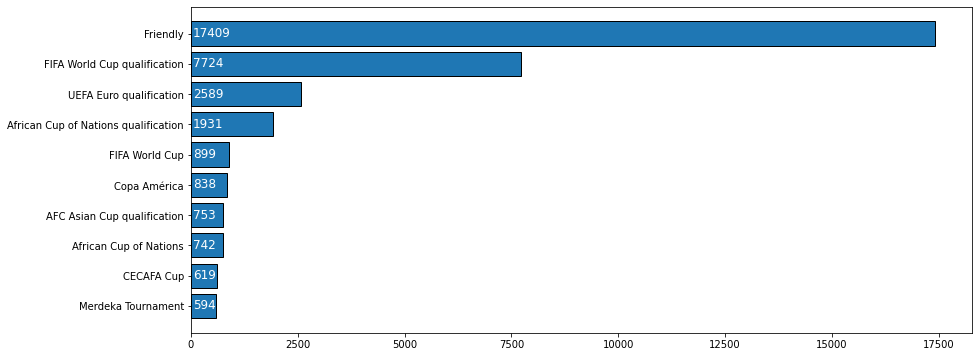

In [113]:
#Tipo de partidas
rank_bound = 10
ax = df.tournament.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

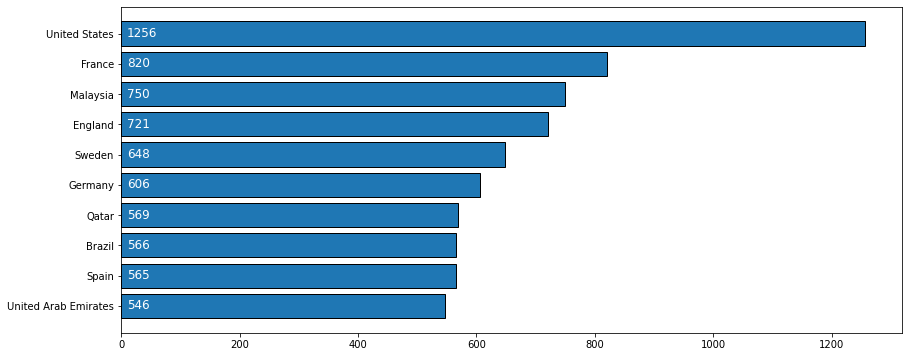

In [114]:
#As equipes jogaram a maioria das partidas
rank_bound = 10
ax = df.country.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=10,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

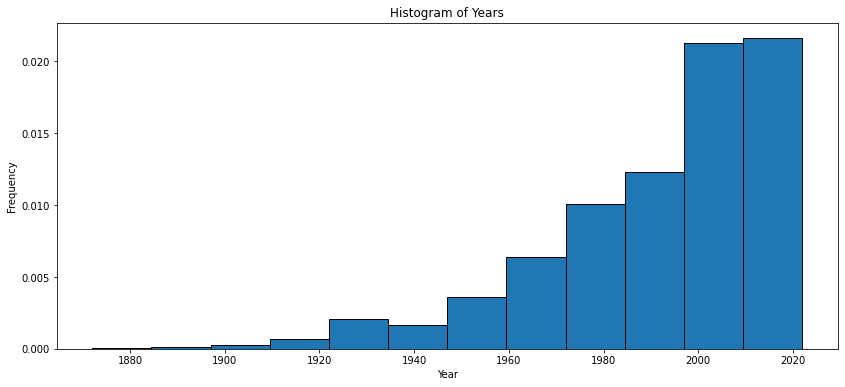

In [115]:
#Número de partidas disputadas em intervalos iguais

years = []
for date in df.date:
    years.append(int(str(date)[0:4]))
plt.figure(figsize=(14,6))
plt.hist(years, density=True, bins=12, edgecolor="k")
plt.title("Histogram of Years")
plt.ylabel("Frequency")
plt.xlabel("Year")
plt.show()

In [116]:
#Descobrir o impacto de sediar um grande torneio ajuda nas chances de vitória de um país?
#Agora pegue os rpws que home_team==Country
#Nad romover os dados dos amistosos

data_home=df.loc[df["home_team"]==df["country"] ]
data_home=df.loc[df["tournament"] != "Friendly"]
data_home.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
29,1884-01-26,Northern Ireland,Scotland,0.0,5.0,British Championship,Belfast,Ireland,False,Lost
30,1884-02-09,Wales,Northern Ireland,6.0,0.0,British Championship,Wrexham,Wales,False,Win
31,1884-02-23,Northern Ireland,England,1.0,8.0,British Championship,Belfast,Ireland,False,Lost
32,1884-03-15,Scotland,England,1.0,0.0,British Championship,Glasgow,Scotland,False,Win
33,1884-03-17,Wales,England,0.0,4.0,British Championship,Wrexham,Wales,False,Lost


In [117]:
# Estatísticas de vitórias do time da casa
#Como o time da casa se sai nas partidas do torneio

tournament_df=pd.crosstab(data_home["tournament"], data_home["Win_Statues"],margins=True)
tournament_df=tournament_df.sort_values("All",ascending=False).head(10)
tournament_df.style.bar(color="brown",subset=["Draw","Lost","Win","All"])

Win_Statues,Draw,Lost,Win,All
tournament,,,,
All,5791,7540,13113,26444
FIFA World Cup qualification,1644,2124,3956,7724
UEFA Euro qualification,510,817,1262,2589
African Cup of Nations qualification,472,378,1081,1931
FIFA World Cup,199,290,410,899
Copa América,181,230,427,838
AFC Asian Cup qualification,126,188,439,753
African Cup of Nations,209,200,333,742
CECAFA Cup,147,185,287,619


Text(0.5, 1.0, 'Home Team Winning Status')

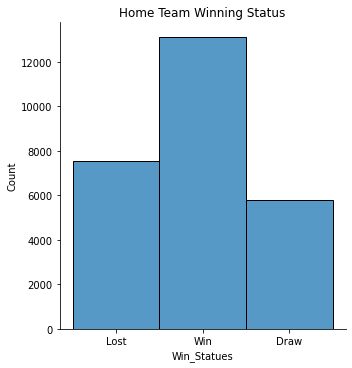

In [118]:
# Resultados do time da casa
sns.displot(data_home, x="Win_Statues")
plt.title("Home Team Winning Status")

In [119]:
data_home['Win_Statues'].value_counts()

Win     13113
Lost     7540
Draw     5791
Name: Win_Statues, dtype: int64

In [120]:
#Como cada equipe se sai durante um torneio em casa

teams_win_statues=pd.crosstab(df["home_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_win_statues["team_win_probability"]=teams_win_statues["Win"]/(teams_win_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_win_statues_100=teams_win_statues.loc[teams_win_statues["Total"]>50]
teams_win_statues_100=teams_win_statues_100.sort_values("team_win_probability",ascending=False)
teams_win_statues_100.head(20).style.bar(color="orange",subset="team_win_probability")

#Podemos ver que as equipes têm mais de 50% de probabilidade de vitória jogando em casa

Win_Statues,Draw,Lost,Win,Total,team_win_probability
home_team,,,,,
Brazil,110,58,422,590,0.715254
Spain,70,51,253,374,0.676471
Argentina,124,68,371,563,0.658970
Czech Republic,20,36,104,160,0.650000
Ivory Coast,67,35,183,285,0.642105
Egypt,69,74,256,399,0.641604
North Korea,23,22,79,124,0.637097
Nigeria,69,36,184,289,0.636678
Iran,63,44,184,291,0.632302


In [121]:
# Estatísticas de vitórias do time visitante
#Equipes jogando fora de casa

teams_away_statues=pd.crosstab(df["away_team"], df["Win_Statues"],margins=True, margins_name="Total")
teams_away_statues["team_win_probability"]=teams_away_statues["Lost"]/(teams_away_statues["Total"])

#Vamos pegar times que jogam pelo menos 50 jogos
teams_away_statues_100=teams_away_statues.loc[teams_away_statues["Total"]>50]
teams_away_statues_100=teams_away_statues_100.sort_values("team_win_probability",ascending=False)
teams_away_statues_100.rename(columns={'Lost': 'Win'}, index={'Win': 'Lost'}, inplace=True)
teams_away_statues_100.head(20)

#A probabilidade de ganhar um torneio fora de casa é muito baixa em comparação com as probabilidades de ganhar em casa

Win_Statues,Draw,Win,Win,Total,team_win_probability
away_team,,,,,
Brazil,95,228,102,425,0.536471
Germany,93,245,119,457,0.536105
England,136,265,117,518,0.511583
Spain,100,168,83,351,0.478632
Tahiti,16,50,43,109,0.458716
Croatia,49,83,50,182,0.456044
Iran,67,101,57,225,0.448889
South Korea,114,181,109,404,0.448020
Netherlands,83,167,129,379,0.440633


In [122]:
teams_away_statues_100["team_win_probability"]

away_team
Brazil           0.536471
Germany          0.536105
England          0.511583
Spain            0.478632
Tahiti           0.458716
                   ...   
Somalia          0.060606
Liechtenstein    0.058824
Seychelles       0.042254
Andorra          0.021505
San Marino       0.000000
Name: team_win_probability, Length: 198, dtype: float64

In [123]:
#fazendo uma cópia do dataframe principal para uso futuro
df_match=df.copy() 
df_match.head(8)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win_Statues
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Win
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Win
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Win
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,Win
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,Lost
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,Lost


In [124]:
#Criando um novo conjunto de dados com os recursos necessários para treinar o modelo de aprendizado de máquina
#Ano,País Jogado,Team_1,team_2,pontuação do time_1,pontuação do time_2
New_Dataset_part_1=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,1],df_match.values[:,2],df_match.values[:,3],df_match.values[:,4])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])

#Criando um novo dataset alterando team_1 e team_2 e suas respectivas pontuações
New_Dataset_part_2=pd.DataFrame(list(zip(years,df_match.values[:,7],df_match.values[:,2],df_match.values[:,1],df_match.values[:,4],df_match.values[:,3])),columns=["year","Country","team_1","team_2","team_1_score","team_2_score"])
New_Dataset=pd.concat([New_Dataset_part_1,New_Dataset_part_2],axis=0)
New_Dataset =New_Dataset.sample(frac=1).reset_index(drop=True) #Shaffling the dataset
New_Dataset.head(5)

,year,Country,team_1,team_2,team_1_score,team_2_score
0,2021,Sri Lanka,Sri Lanka,Seychelles,3.0,3.0
1,2013,Lesotho,Ghana,Lesotho,2.0,0.0
2,2012,Poland,Italy,Republic of Ireland,2.0,0.0
3,2002,United States,United States,Ecuador,1.0,0.0
4,1988,Paraguay,Uruguay,Ecuador,2.0,1.0


In [125]:
#Criando uma lista contendo todos os nomes dos países
teams_1=New_Dataset.team_1.unique()
contries=New_Dataset.Country.unique()
all_countries=np.unique(np.concatenate((teams_1,contries), axis=0))
len(all_countries)

349

,year,team_1_score,team_2_score
year,1.000000,-0.128843,-0.128843
team_1_score,-0.128843,1.000000,-0.156674
team_2_score,-0.128843,-0.156674,1.000000


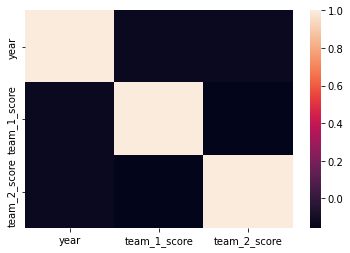

In [126]:
#Fazendo um mapa de calor para ver a correlação de cada coluna
sns.heatmap(New_Dataset.corr())
New_Dataset.corr()

In [127]:
#Definindo as features e labels(Targets)
Y= New_Dataset.iloc[:,4:6]                                                      # Metas de treinamento (team_1_score e team_2_score)
categorized_data=New_Dataset.iloc[:,0:4].copy()                                 # Recursos de treinamento

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

#Rotulando os dados usando LabelEncorder no Sklearn-(Dando um número único para cada string(país))
label_encoder.fit(all_countries)

#list(label_encoder.classes_)
categorized_data['team_1']=label_encoder.transform(categorized_data['team_1'])
categorized_data['team_2']=label_encoder.transform(categorized_data['team_2'])
categorized_data['Country']=label_encoder.transform(categorized_data['Country'])

#Convertendo essas colunas de recursos para categorizar o formulário para tornar o processo de treinamento mais suave
categorized_data['team_1']=categorized_data['team_1'].astype("category")
categorized_data['team_2']=categorized_data['team_2'].astype("category")
categorized_data['Country']=categorized_data['team_2'].astype("category")

In [128]:
#Características de entrada para o modelo (x)
categorized_data.head(5)

,year,Country,team_1,team_2
0,2021,267,285,267
1,2013,166,115,166
2,2012,243,147,243
3,2002,89,318,89
4,1988,89,321,89


In [129]:
Y.head(5)

,team_1_score,team_2_score
0,3.0,3.0
1,2.0,0.0
2,2.0,0.0
3,1.0,0.0
4,2.0,1.0


In [130]:
#Informações sobre os dataframes X e Y
print(categorized_data.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   year     87706 non-null  int64   
 1   Country  87706 non-null  category
 2   team_1   87706 non-null  category
 3   team_2   87706 non-null  category
dtypes: category(3), int64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87706 entries, 0 to 87705
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team_1_score  87706 non-null  float64
 1   team_2_score  87706 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


In [131]:
#Fazendo o modelo
X=categorized_data
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [132]:
#Use qualquer algoritmo
model = MultiOutputRegressor(GradientBoostingClassifier())
model.fit(X,Y)

MultiOutputRegressor(estimator=GradientBoostingClassifier())

In [133]:
#Fazendo as previsões
prd=model.predict(X)
prd

array([[1., 1.],
       [1., 0.],
       [1., 1.],
       ...,
       [0., 1.],
       [1., 1.],
       [0., 1.]])

In [134]:
#Criando a matriz de confusão para cada previsão
score_team_1=[i[0] for i in prd]
score_team_2=[i[1] for i in prd]

from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(list(Y.iloc[:,0]),score_team_1)
cm2=confusion_matrix(list(Y.iloc[:,1]),score_team_2)

Text(159.0, 0.5, 'Predicted')

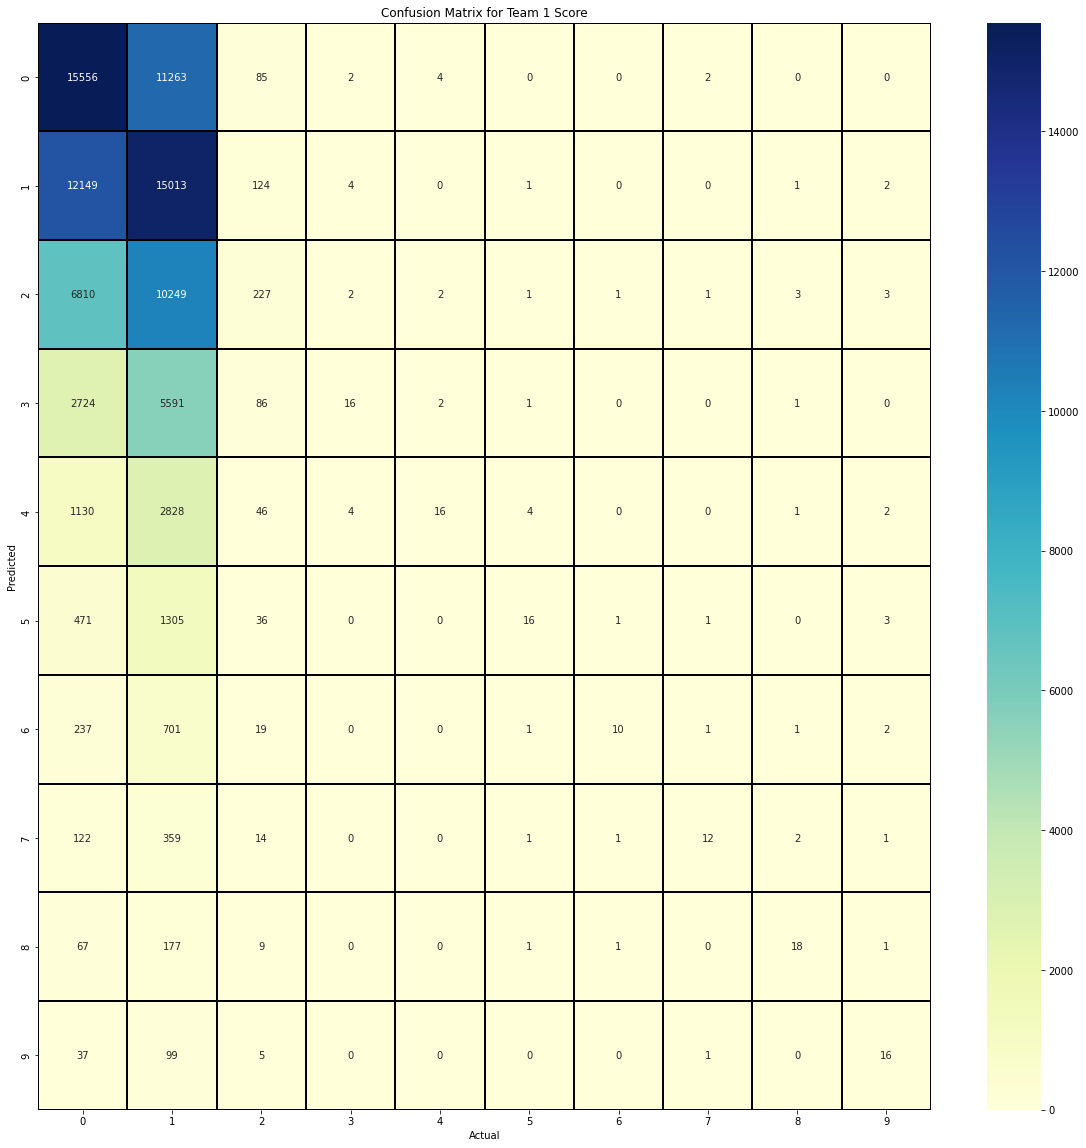

In [135]:
#Traçando a Matriz de Confusão para pontuação da equipe 01
plt.figure(figsize=(20,20))
sns.heatmap(cm1, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for Team 1 Score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [136]:
#Relatório de classificação para equipe 1 Pontuação
from sklearn.metrics import classification_report
report_1=classification_report(Y.iloc[:,0],score_team_1)
print(report_1)

#Tem uma boa Precisão em prever a pontuação da equipe 1

              precision    recall  f1-score   support

         0.0       0.40      0.58      0.47     26912
         1.0       0.32      0.55      0.40     27294
         2.0       0.35      0.01      0.03     17299
         3.0       0.57      0.00      0.00      8421
         4.0       0.67      0.00      0.01      4031
         5.0       0.62      0.01      0.02      1833
         6.0       0.71      0.01      0.02       972
         7.0       0.67      0.02      0.05       512
         8.0       0.67      0.07      0.12       274
         9.0       0.53      0.10      0.17       158

    accuracy                           0.35     87706
   macro avg       0.55      0.14      0.13     87706
weighted avg       0.40      0.35      0.28     87706



Text(159.0, 0.5, 'Predicted')

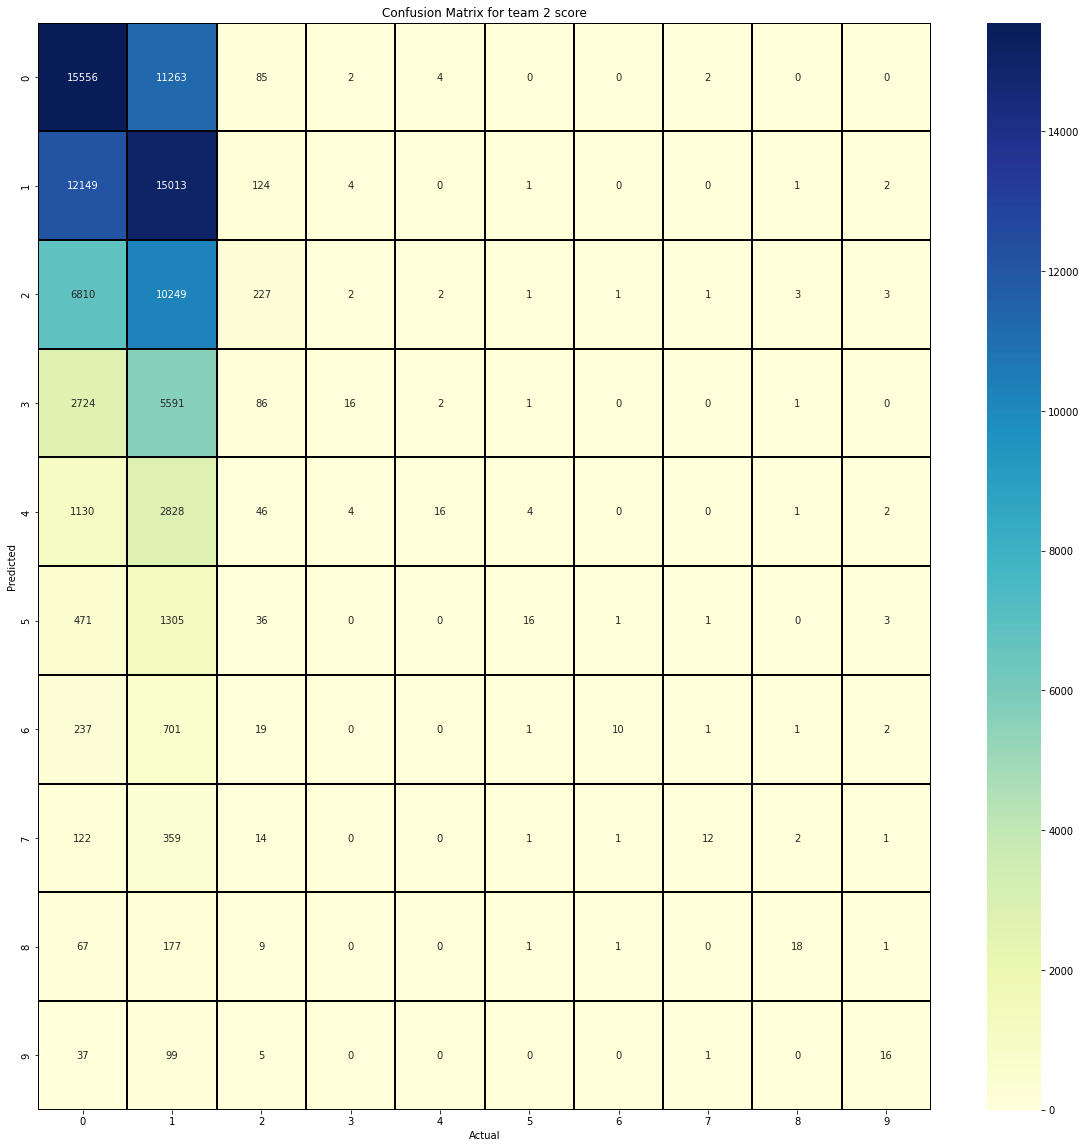

In [137]:
#Traçando a Matriz de Confusão para pontuação da equipe 02
plt.figure(figsize=(20,20))
sns.heatmap(cm2, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1)
plt.title("Confusion Matrix for team 2 score")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [138]:
#Relatório de classificação para equipe 2 Pontuação
report_2=classification_report(Y.iloc[:,1],score_team_2)
print(report_2)

#Tem uma boa Precisão em prever a pontuação da equipe 1#

              precision    recall  f1-score   support

         0.0       0.40      0.58      0.47     26912
         1.0       0.32      0.55      0.40     27294
         2.0       0.35      0.01      0.03     17299
         3.0       0.57      0.00      0.00      8421
         4.0       0.67      0.00      0.01      4031
         5.0       0.62      0.01      0.02      1833
         6.0       0.71      0.01      0.02       972
         7.0       0.67      0.02      0.05       512
         8.0       0.67      0.07      0.12       274
         9.0       0.53      0.10      0.17       158

    accuracy                           0.35     87706
   macro avg       0.55      0.14      0.13     87706
weighted avg       0.40      0.35      0.28     87706



In [139]:
#Função para selecionar a equipe vencedora para a matriz de previsão
def select_winning_team(probability_array):
    prob_lst=[round(probability_array[0][i],3) for i in range(2)]
    if (prob_lst[0]>prob_lst[1]):
        out=0
    elif (prob_lst[0]<prob_lst[1]):
        out=1
    elif (prob_lst[0]==prob_lst[1]):
        out=2
    return out,prob_lst

In [140]:
#Previsão de amostra
mactch_played=2015
team_1="Brazil"
team_2="Argentina"
stadium="Qatar"

team_lst=[team_1,team_2]
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
stadium_num=label_encoder.transform([stadium])[0]

print(f"Team 01 is {team_1} -{team_1_num}")
print(f"Team 02 is {team_2} -{team_2_num}")
print(f"Played in  {stadium} -{stadium_num}")

Team 01 is Brazil -41
Team 02 is Argentina -12
Played in  Qatar -241


In [141]:
#saída de previsão de amostra
X_feature=np.array([[mactch_played,stadium_num,team_1_num,team_2_num]])
res=model.predict(X_feature)
win,_=select_winning_team(res)
try:
    print(f"{team_1} vs {team_2} \n {team_lst[win]} wins 🏆⚽🎯\n")
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽⚽\n") 

Brazil vs Argentina 
  Match Draw ⚽⚽⚽



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


WORLD CUP 2022

In [142]:
Group_A= ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B= ["England","Iran","United States","Wales"]
Group_C= ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D= ["France","Australia","Denmark","Nigeria"]
Group_E= ["Spain","Costa Rica","Germany","Japan"]
Group_F= ["Belgium","Canada","Morocco","Croatia"]
Group_G= ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H= ["Portugal","Ghana","Uruguay","South Korea"]
Groups={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,"Group F":Group_F,"Group G":Group_G,"Group H":Group_H}


In [143]:
#Inicializar parâmetros básicos
year=2022
stadium="Qatar"
stadium_num=label_encoder.transform([stadium])[0]
host_num=stadium_num

In [144]:
#Jogos da fase de grupos

Group_standings={}
for grp_name in list(Groups.keys()):
    print(f"{grp_name} Matches")
    probable_countries=Groups[grp_name]
    team_wins_dct={}
    goal_scored_dct={}
    goal_against_dct={}
    win_dct={}
    draw_dct={}
    lost_dct={}
    for i in range(len(probable_countries)):
        j=i+1
        team_1=probable_countries[i]
        team_1_num=label_encoder.transform([team_1])[0]
        team_wins=0
        while j<len((probable_countries)):
            team_2=probable_countries[j]
            team_2_num=label_encoder.transform([team_2])[0]
            team_lst=[team_1,team_2]
            Input_vector=np.array([[year,stadium_num,team_1_num,team_2_num]])
            res=model.predict(Input_vector)

            win,prob_lst=select_winning_team(res)
            goal_scored_dct[team_1] = goal_scored_dct.get(team_1,0)+prob_lst[0]
            goal_scored_dct[team_2] = goal_scored_dct.get(team_2,0)+prob_lst[1]

            goal_against_dct[team_1] = goal_against_dct.get(team_1,0)+prob_lst[1]
            goal_against_dct[team_2] = goal_against_dct.get(team_2,0)+prob_lst[0]

            try:
                print(f" {team_1} vs {team_2} \n  Results of the Match {res[0]}\n   {team_lst[win]} wins 🎊🏆⚽🎖️\n")
                if (win)==0:
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+2
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)
                    
                    win_dct[team_1] = win_dct.get(team_1,0)+1
                    win_dct[team_2] = win_dct.get(team_2,0)
                    lost_dct[team_2] = lost_dct.get(team_2,0)+1
                    lost_dct[team_1] = lost_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)

                elif (win)==1:
                    team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+2
                    team_wins_dct[team_1] = team_wins_dct.get(team_1,0)
                    
                    win_dct[team_2] = win_dct.get(team_2,0)+1
                    win_dct[team_1] = win_dct.get(team_1,0)
                    lost_dct[team_1] = lost_dct.get(team_1,0)+1
                    lost_dct[team_2] = lost_dct.get(team_2,0)
                    draw_dct[team_1] = draw_dct.get(team_1,0)
                    draw_dct[team_2] = draw_dct.get(team_2,0)

            except IndexError:
                print(f"{team_1} vs {team_2} \n  Results of the Match {res[0]}\n   Match Draw ⚽⚽⚽\n") 
                team_wins_dct[team_1] = team_wins_dct.get(team_1,0)+1
                team_wins_dct[team_2] = team_wins_dct.get(team_2,0)+1
                
                draw_dct[team_1] = draw_dct.get(team_1,0)+1
                draw_dct[team_2] = draw_dct.get(team_2,0)+1
                
                win_dct[team_1] = win_dct.get(team_1,0)
                lost_dct[team_1] = lost_dct.get(team_1,0)
                
                win_dct[team_2] = win_dct.get(team_2,0)
                lost_dct[team_2] = lost_dct.get(team_2,0)
                    
            j=j+1
    group_results=[win_dct,draw_dct,lost_dct,team_wins_dct,goal_scored_dct,goal_against_dct]
    Group_standings[grp_name]=group_results

Group A Matches
 Qatar vs Ecuador 
  Results of the Match [1. 0.]
   Qatar wins 🎊🏆⚽🎖️

Qatar vs Senegal 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Qatar vs Netherlands 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Ecuador vs Senegal 
  Results of the Match [0. 1.]
   Senegal wins 🎊🏆⚽🎖️

 Ecuador vs Netherlands 
  Results of the Match [0. 1.]
   Netherlands wins 🎊🏆⚽🎖️

Senegal vs Netherlands 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Group B Matches
 England vs Iran 
  Results of the Match [1. 0.]
   England wins 🎊🏆⚽🎖️

 England vs United States 
  Results of the Match [1. 0.]
   England wins 🎊🏆⚽🎖️

 England vs Wales 
  Results of the Match [1. 0.]
   England wins 🎊🏆⚽🎖️

 Iran vs United States 
  Results of the Match [1. 0.]
   Iran wins 🎊🏆⚽🎖️

 Iran vs Wales 
  Results of the Match [1. 0.]
   Iran wins 🎊🏆⚽🎖️

United States vs Wales 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Group C Matches
Argentina vs Saudi Arabia 
  Results of the Match [1. 1.]
   Match 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

France vs Denmark 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

France vs Nigeria 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Australia vs Denmark 
  Results of the Match [0. 1.]
   Denmark wins 🎊🏆⚽🎖️

Australia vs Nigeria 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Denmark vs Nigeria 
  Results of the Match [0. 1.]
   Nigeria wins 🎊🏆⚽🎖️

Group E Matches
 Spain vs Costa Rica 
  Results of the Match [1. 0.]
   Spain wins 🎊🏆⚽🎖️

 Spain vs Germany 
  Results of the Match [1. 0.]
   Spain wins 🎊🏆⚽🎖️

 Spain vs Japan 
  Results of the Match [1. 0.]
   Spain wins 🎊🏆⚽🎖️

 Costa Rica vs Germany 
  Results of the Match [0. 1.]
   Germany wins 🎊🏆⚽🎖️

 Costa Rica vs Japan 
  Results of the Match [0. 1.]
   Japan wins 🎊🏆⚽🎖️

Germany vs Japan 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Group F Matches
Belgium vs Canada 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

 Belgium vs Morocco 
  Results of the Match [0. 1.]
   Morocco wins 🎊🏆⚽🎖️

Belgium vs Croatia 
  Result

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

 Canada vs Croatia 
  Results of the Match [0. 1.]
   Croatia wins 🎊🏆⚽🎖️

 Morocco vs Croatia 
  Results of the Match [0. 1.]
   Croatia wins 🎊🏆⚽🎖️

Group G Matches
 Brazil vs Serbia 
  Results of the Match [1. 0.]
   Brazil wins 🎊🏆⚽🎖️

 Brazil vs Switzerland 
  Results of the Match [1. 0.]
   Brazil wins 🎊🏆⚽🎖️

Brazil vs Cameroon 
  Results of the Match [0. 0.]
   Match Draw ⚽⚽⚽

Serbia vs Switzerland 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

 Serbia vs Cameroon 
  Results of the Match [0. 1.]
   Cameroon wins 🎊🏆⚽🎖️

 Switzerland vs Cameroon 
  Results of the Match [0. 1.]
   Cameroon wins 🎊🏆⚽🎖️

Group H Matches
Portugal vs Ghana 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Portugal vs Uruguay 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Portugal vs South Korea 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Ghana vs Uruguay 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Ghana vs South Korea 
  Results of the Match [1. 1.]
   Match Draw ⚽⚽⚽

Uruguay vs Sout

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

In [145]:
#Exibir resultados da fase de grupos
for grp_name in list(Group_standings.keys()):

    team_wins_dct= dict(sorted(Group_standings[grp_name][3].items()))
    goal_scored_dct=dict(sorted(Group_standings[grp_name][4].items()))
    goal_against_dct=dict(sorted(Group_standings[grp_name][5].items()))
    
    win_dct=dict(sorted(Group_standings[grp_name][0].items()))
    draw_dct=dict(sorted(Group_standings[grp_name][1].items()))
    lost_dct=dict(sorted(Group_standings[grp_name][2].items()))
    
    lst_teams=list(team_wins_dct.keys())
    
    win_lst=list(win_dct.values())
    draw_lst=list(draw_dct.values())
    lost_lst=list(lost_dct.values())
    
    lst_win_count=list(team_wins_dct.values())
    goal_scored=list(goal_scored_dct.values())
    goal_against=list(goal_against_dct.values())
    goal_differance=[goal_scored[i]-goal_against[i] for i in range (len(goal_scored))]
    ranking_table=pd.DataFrame(list(zip(lst_teams,win_lst,draw_lst,lost_lst,goal_scored,goal_against,goal_differance,lst_win_count)),columns=["Team","Wins","Draw","Lost","Goal Scored","Goal Against","Goal Differance","Points"])
    ranking_table=ranking_table.sort_values("Points",ascending=False).reset_index(drop=True)
    ranking_table.index = ranking_table.index + 1
    print(f"\n\n{grp_name} Final Rankings")
    print(ranking_table.to_markdown())
    



Group A Final Rankings
|    | Team        |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | Netherlands |      1 |      2 |      0 |             1 |              0 |                 1 |        4 |
|  2 | Qatar       |      1 |      2 |      0 |             2 |              1 |                 1 |        4 |
|  3 | Senegal     |      1 |      2 |      0 |             2 |              1 |                 1 |        4 |
|  4 | Ecuador     |      0 |      0 |      3 |             0 |              3 |                -3 |        0 |


Group B Final Rankings
|    | Team          |   Wins |   Draw |   Lost |   Goal Scored |   Goal Against |   Goal Differance |   Points |
|---:|:--------------|-------:|-------:|-------:|--------------:|---------------:|------------------:|---------:|
|  1 | England       |      3 |      0 |      0 | 

In [146]:
#Round of 16 Section_1
qualified_teams_1=[]
standings=list(Group_standings.keys())
i=0
print(f"Round of 16\n")
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[0][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[1][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(team_lst[win])
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_1.append(winning_team)
    i=i+2
    
##Round of 16 Section_2
qualified_teams_2=[]
standings=list(Group_standings.keys())
i=0
while i < (len(standings)):
    A_team= sorted(Group_standings[standings[i]][3].items(), key=lambda x: x[1], reverse=True)
    team_1=A_team[1][0]
    B_team= sorted(Group_standings[standings[i+1]][3].items(), key=lambda x: x[1], reverse=True)
    team_2=B_team[0][0]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Quater-Finals ⏩⏩ \n")
            qualified_teams_2.append(winning_team)
    i=i+2

Round of 16

Qatar vs Iran 
  Match Draw ⚽⚽
   Iran wins at Penaly Shoot-Out 🥅🎯
    Iran into the Quater-Finals ⏩⏩ 

Argentina vs France 
  Match Draw ⚽⚽
   France wins at Penaly Shoot-Out 🥅🎯
    France into the Quater-Finals ⏩⏩ 

Spain vs Morocco 
  Spain wins 🏆🏆
    Spain into the Quater-Finals ⏩⏩ 

Brazil vs Ghana 
  Brazil wins 🏆🏆
    Brazil into the Quater-Finals ⏩⏩ 

Senegal vs England 
  England wins 🏆🏆
    England into the Quater-Finals ⏩⏩ 

Saudi Arabia vs Nigeria 
  Match Draw ⚽⚽
   Nigeria wins at Penaly Shoot-Out 🥅🎯
    Nigeria into the Quater-Finals ⏩⏩ 

Germany vs Croatia 
  Match Draw ⚽⚽
   Germany wins at Penaly Shoot-Out 🥅🎯
    Germany into the Quater-Finals ⏩⏩ 

Cameroon vs Portugal 
  Portugal wins 🏆🏆
    Portugal into the Quater-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

In [147]:
print(f"Teams selected to the Quater Finals - {qualified_teams_1+qualified_teams_2}")

Teams selected to the Quater Finals - ['Iran', 'France', 'Spain', 'Brazil', 'England', 'Nigeria', 'Germany', 'Portugal']


In [148]:
#Quartas de final
Semifinal_teams=[]
i=0
print(f"Quater Final Matches\n")
while i < (len(qualified_teams_1))-1:
    team_1= qualified_teams_1[i]
    team_2= qualified_teams_1[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽")
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2
    
i=0
while i < (len(qualified_teams_2))-1:
    team_1= qualified_teams_2[i]
    team_2= qualified_teams_2[i+1]
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(team_lst[win])
            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the Semi-Finals ⏩⏩ \n")
            Semifinal_teams.append(winning_team)
    i=i+2

Quater Final Matches

Iran vs France 
  Match Draw ⚽⚽
   France wins at Penaly Shoot-Out 🥅🎯
    France into the Semi-Finals ⏩⏩ 

Spain vs Brazil 
  Spain wins 🏆🏆
    Spain into the Semi-Finals ⏩⏩ 

England vs Nigeria 
  England wins 🏆🏆
    England into the Semi-Finals ⏩⏩ 

Germany vs Portugal 
  Match Draw ⚽⚽
   Portugal wins at Penaly Shoot-Out 🥅🎯
    Portugal into the Semi-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

In [149]:
print(f"Teams selected to the Semi-Finals - {Semifinal_teams}")

Teams selected to the Semi-Finals - ['France', 'Spain', 'England', 'Portugal']


In [150]:
#Semifinais
final_teams=[]
third_place_match_teams=[]
i=0
print(f"Semi Final Matches\n")
while i < (len(Semifinal_teams))-1:
    team_1= Semifinal_teams[i]
    team_2= Semifinal_teams[i+1]
    
    team_1_num=label_encoder.transform([team_1])[0]
    team_2_num=label_encoder.transform([team_2])[0]
    team_lst=[team_1,team_2]
    
    Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
    res=model.predict(Input_vector)
    win,_=select_winning_team(res)

    try:
            print(f"{team_1} vs {team_2} \n  {team_lst[win]} wins 🏆🏆")
            print(f"    {team_lst[win]} into the FiIFA-Finals ⏩⏩ \n")
            final_teams.append(team_lst[win])
            third_place_match_teams.append(team_lst[(win+1)%2])

            
    except IndexError:
            print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
            winning_team=random.choice(team_lst)
            print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
            print(f"    {winning_team} into the FIFA-Finals ⏩⏩ \n")
            final_teams.append(winning_team)
            team_lst.remove(winning_team)
            third_place_match_teams.append(team_lst[0])
    i=i+2
    

Semi Final Matches

France vs Spain 
  Match Draw ⚽⚽
   Spain wins at Penaly Shoot-Out 🥅🎯
    Spain into the FIFA-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


England vs Portugal 
  England wins 🏆🏆
    England into the FiIFA-Finals ⏩⏩ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


##FINAL

In [151]:
print(f"Teams selected to the Finals - {final_teams}")
print(f"Teams selected to the Third Place match - {third_place_match_teams}")

Teams selected to the Finals - ['Spain', 'England']
Teams selected to the Third Place match - ['France', 'Portugal']


In [152]:
#Finais e disputa do terceiro lugar
print(f"FiIFA FINAl\n")
team_1= final_teams[1]
team_2= final_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} are the Winners 🎉🏆🎉\n\n")
    winner=team_lst[win]
    place_2=team_lst[(win+1)%2]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} are the Winners 🎉🏆🎉\n\n")
    winner=winning_team
    
    team_lst.remove(winning_team)
    place_2=team_lst[0]

print(f"Third Place match\n")
team_1= third_place_match_teams[1]
team_2= third_place_match_teams[0]
    
team_1_num=label_encoder.transform([team_1])[0]
team_2_num=label_encoder.transform([team_2])[0]
team_lst=[team_1,team_2]
    
Input_vector=np.array([[year,host_num,team_1_num,team_2_num]])
res=model.predict(Input_vector)
win,_=select_winning_team(res)

try:
    print(f"{team_1} vs {team_2} \n  {team_lst[win]} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=team_lst[win]
            
except IndexError:
    print(f"{team_1} vs {team_2} \n  Match Draw ⚽⚽") 
    winning_team=random.choice(team_lst)
    print(f"   {winning_team} wins at Penaly Shoot-Out 🥅🎯")
    print(f"    {winning_team} Wins the 3rd Place 🎉🏆🎉\n")
    place_3=winning_team
    

    
print(f"\n\nWinner is {winner} 🥇🥇🥇")
print(f"Runner-up is {place_2} 🥈🥈🥈")
print(f"3rd Place is {place_3} 🥉🥉🥉")

FiIFA FINAl

England vs Spain 
  England are the Winners 🎉🏆🎉


Third Place match

Portugal vs France 
  France Wins the 3rd Place 🎉🏆🎉



Winner is England 🥇🥇🥇
Runner-up is Spain 🥈🥈🥈
3rd Place is France 🥉🥉🥉


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
